# Importer Libraries et Données

In [1]:
%load_ext autoreload
%autoreload 2

In [51]:
# import libraries
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import umap.umap_ as umap
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# sns.set_style('whitegrid')

In [3]:
# import data
df = pd.read_csv('data/df_model_final.csv')
df.shape

(100736, 29)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100736 entries, 0 to 100735
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   order_purchase_timestamp    100736 non-null  object 
 1   product_name_length         100736 non-null  float64
 2   product_description_length  100736 non-null  float64
 3   product_photos_qty          100736 non-null  float64
 4   payment_installments        100736 non-null  float64
 5   number_of_reviews           100736 non-null  float64
 6   review_score                100736 non-null  float64
 7   price_log                   100736 non-null  float64
 8   distance                    100736 non-null  float64
 9   freight_price_ratio         100736 non-null  float64
 10  delivery_time_days          100736 non-null  int64  
 11  Respect_delivery_bool       100736 non-null  int64  
 12  Respect_shipping_bool       100736 non-null  int64  
 13  volumn_cm3    

In [5]:
df.drop(columns=['order_purchase_timestamp'], inplace=True)
df.shape

(100736, 28)

In [6]:
def plot_dendrogram(
    model: AgglomerativeClustering, title: str, xlabel: str, y: int, **kwargs
):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    plt.title(title)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.axhline(y=y, color="r", linestyle="--")
    plt.xlabel(xlabel)
    plt.show()

In [25]:
def plot_clusters(x, y, data, hue, title=None):
    sns.lmplot(
        x=x,
        y=y,
        data=data,
        legend=True,
        height=9,
        hue=hue,
        scatter_kws={"s": 10, "alpha": 0.3},
        fit_reg=False,
    )

    if title is not None:
        plt.title(title, fontdict={'fontsize': 15})
    plt.show()

In [177]:
def plot_radar(cluster: list, title:str=None) -> None:
    labels = df.columns.to_list()
    labels = [*labels[:-1], labels[0]]
    fig = go.Figure(
        data=[
            go.Scatterpolar(
                r=cluster,
                theta=labels,
                fill="toself",
            )
        ],
        layout=go.Layout(
            title=go.layout.Title(text=title),
            polar={"radialaxis": {"visible": True}},
            
        ),
    )
    fig.update_layout(template=None)
    pyo.iplot(fig)

# Standard Scaler

In [7]:
scaler = StandardScaler()
df_ss = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_ss.describe()

product_name_length  product_description_length  product_photos_qty  \
count         1.007360e+05                1.007360e+05        1.007360e+05   
mean          1.303137e-16               -8.309039e-17       -8.421895e-17   
std           1.000005e+00                1.000005e+00        1.000005e+00   
min          -4.199601e+00               -1.190623e+00       -1.265218e+00   
25%          -5.391647e-01               -6.706812e-01       -6.945499e-01   
50%           3.323678e-01               -2.772940e-01       -6.945499e-01   
75%           7.681340e-01                3.127868e-01        4.467861e-01   
max           2.424046e+00                4.896205e+00        1.014814e+01   

       payment_installments  number_of_reviews  review_score     price_log  \
count          1.007360e+05       1.007360e+05  1.007360e+05  1.007360e+05   
mean          -1.340168e-17       9.021444e-17 -1.156776e-17  1.857190e-16   
std            1.000005e+00       1.000005e+00  1.000005e+00  1.000005e+00   
min           -1.062300e+00      -8.957256e+00 -3.116391e+00 -4.895655e+00   
25%           -6.897814e-01       9.524355e-03 -9.576756e-02 -6.864287e-01   
50%           -6.897814e-01       9.524355e-03  6.593882e-01  1.565952e-02   
75%            4.277732e-01       9.524355e-03  6.593882e-01  6.339677e-01   
max            7.878137e+00       1.794308e+01  6.593882e-01  4.833405e+00   

           distance  freight_price_ratio  delivery_time_days  ...  \
count  1.007360e+05         1.007360e+05        1.007360e+05  ...   
mean  -1.408234e-16         7.152263e-17        6.348162e-17  ...   
std    1.000005e+00         1.000005e+00        1.000005e+00  ...   
min   -8.573698e-01        -4.061017e+01       -1.266949e+00  ...   
25%   -7.766561e-01        -5.193039e-01       -6.390431e-01  ...   
50%   -2.736430e-01        -2.257265e-01       -2.204395e-01  ...   
75%    3.373412e-01         1.741228e-01        3.028151e-01  ...   
max    1.279914e+01         1.910171e+01        2.060509e+01  ...   

          same_city    same_state       weekend       holiday  order_status  \
count  1.007360e+05  1.007360e+05  1.007360e+05  1.007360e+05  1.007360e+05   
mean  -5.900264e-17  1.165946e-16 -6.947711e-17 -5.360670e-18  3.384064e-15   
std    1.000005e+00  1.000005e+00  1.000005e+00  1.000005e+00  1.000005e+00   
min   -2.319267e-01 -7.486117e-01 -5.455664e-01 -1.537907e+00 -1.295698e+02   
25%   -2.319267e-01 -7.486117e-01 -5.455664e-01 -1.537907e+00  7.717848e-03   
50%   -2.319267e-01 -7.486117e-01 -5.455664e-01  6.502344e-01  7.717848e-03   
75%   -2.319267e-01  1.335806e+00 -5.455664e-01  6.502344e-01  7.717848e-03   
max    4.311707e+00  1.335806e+00  1.832958e+00  6.502344e-01  7.717848e-03   

       product_category_label  payment_type_boleto  payment_type_credit_card  \
count            1.007360e+05         1.007360e+05              1.007360e+05   
mean            -5.127904e-17         1.410703e-19             -1.694254e-16   
std              1.000005e+00         1.000005e+00              1.000005e+00   
min             -9.462578e-01        -4.850586e-01             -1.688290e+00   
25%             -7.178098e-01        -4.850586e-01             -1.688290e+00   
50%             -2.609137e-01        -4.850586e-01              5.923153e-01   
75%              6.528784e-01        -4.850586e-01              5.923153e-01   
max              3.394255e+00         2.061607e+00              5.923153e-01   

       payment_type_debit_card  payment_type_voucher  
count             1.007360e+05          1.007360e+05  
mean              1.660221e-17          2.786138e-17  
std               1.000005e+00          1.000005e+00  
min              -1.223195e-01         -2.401069e-01  
25%              -1.223195e-01         -2.401069e-01  
50%              -1.223195e-01         -2.401069e-01  
75%              -1.223195e-01         -2.401069e-01  
max               8.175310e+00          4.164812e+00  

[8 rows x 28 columns]

## Clustering
### Clustering Hiérarchique

In [8]:
df_ss.sample(5)

product_name_length  product_description_length  product_photos_qty  \
48937             0.855287                   -0.175135           -0.123882   
82608            -0.364858                   -0.501433           -0.694550   
17952             0.942441                   -0.367255            1.017454   
91003             0.070908                    1.332849           -0.123882   
44305             0.593828                    0.608590           -0.694550   

       payment_installments  number_of_reviews  review_score  price_log  \
48937              2.662882           0.009524      0.659388   2.379750   
82608              0.055255           0.009524     -0.850923  -0.749313   
17952             -0.689781           0.009524     -1.606079  -1.033999   
91003             -0.689781           0.009524     -0.095768   1.517959   
44305             -0.689781           0.009524      0.659388   1.125519   

       distance  freight_price_ratio  delivery_time_days  ...  same_city  \
48937 -0.838396            -0.946540           -0.952996  ...  -0.231927   
82608 -0.337686             0.242699            0.930721  ...  -0.231927   
17952 -0.268105            -0.033938           -0.534392  ...  -0.231927   
91003 -0.828647            -0.706316            0.302815  ...  -0.231927   
44305  0.340063             2.283675            0.512117  ...  -0.231927   

       same_state   weekend   holiday  order_status  product_category_label  \
48937    1.335806  1.832958  0.650234      0.007718                0.195982   
82608   -0.748612 -0.545566 -1.537907      0.007718               -0.946258   
17952   -0.748612 -0.545566  0.650234      0.007718               -0.717810   
91003    1.335806 -0.545566  0.650234      0.007718               -0.489362   
44305   -0.748612 -0.545566  0.650234      0.007718                1.109775   

       payment_type_boleto  payment_type_credit_card  payment_type_debit_card  \
48937            -0.485059                  0.592315                 -0.12232   
82608            -0.485059                  0.592315                 -0.12232   
17952            -0.485059                  0.592315                 -0.12232   
91003            -0.485059                 -1.688290                 -0.12232   
44305             2.061607                 -1.688290                 -0.12232   

       payment_type_voucher  
48937             -0.240107  
82608             -0.240107  
17952             -0.240107  
91003              4.164812  
44305             -0.240107  

[5 rows x 28 columns]

In [32]:
%%time
# setting distance_threshold=0 ensures we compute the full tree.
ac_40k = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
ac_40k = ac_40k.fit(df_ss.sample(40000))

CPU times: user 1min 9s, sys: 2.65 s, total: 1min 12s
Wall time: 1min 12s


In [28]:
# with open('model/agglo_cluster_40k.pkl', 'wb') as f:
#     pickle.dump(ac_40k, f)

In [ ]:
# with open('model/agglo_cluster_40k.pkl', 'rb') as f:
#     pickle.load(ac_40k, f)

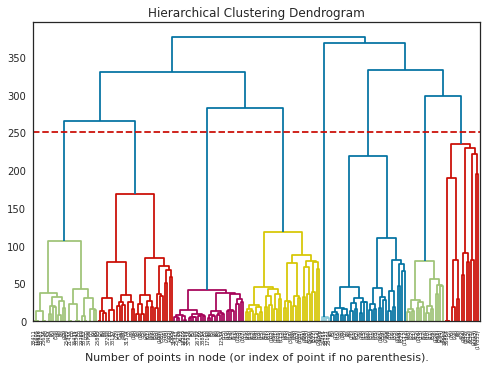

CPU times: user 3.48 s, sys: 472 ms, total: 3.95 s
Wall time: 3.41 s


In [36]:
%%time
title = "Hierarchical Clustering Dendrogram"
xlabel = "Number of points in node (or index of point if no parenthesis)."
# plot the top seven levels of the dendrogram
plot_dendrogram(ac_40k, title=title, xlabel=xlabel, y=250, truncate_mode="level", p=7)

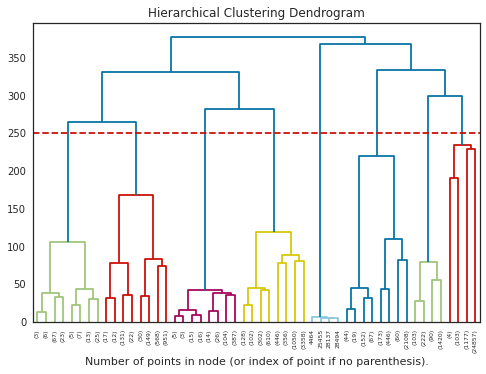

CPU times: user 1.64 s, sys: 268 ms, total: 1.91 s
Wall time: 1.37 s


In [34]:
%%time
title = "Hierarchical Clustering Dendrogram"
xlabel = "Number of points in node (or index of point if no parenthesis)."
# plot the top five levels of the dendrogram
plot_dendrogram(ac_40k, title=title, xlabel=xlabel, y=250, truncate_mode="level", p=5)

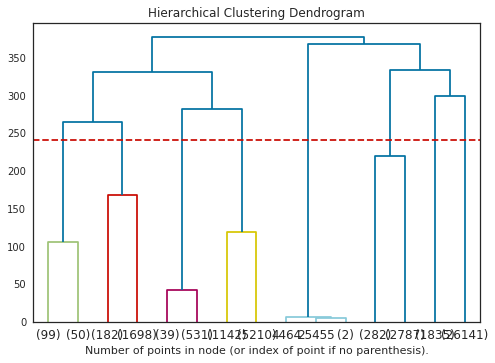

CPU times: user 475 ms, sys: 168 ms, total: 643 ms
Wall time: 355 ms


In [35]:
%%time
title = "Hierarchical Clustering Dendrogram"
xlabel = "Number of points in node (or index of point if no parenthesis)."
# plot the top three levels of the dendrogram
plot_dendrogram(ac_40k, title=title, xlabel=xlabel, y=240, truncate_mode="level", p=3)

In [14]:
%%time
# setting distance_threshold=0 ensures we compute the full tree.
ac30k = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
ac30k = ac30k.fit(df_ss[:30000])

CPU times: user 40.6 s, sys: 1.81 s, total: 42.4 s
Wall time: 42.3 s


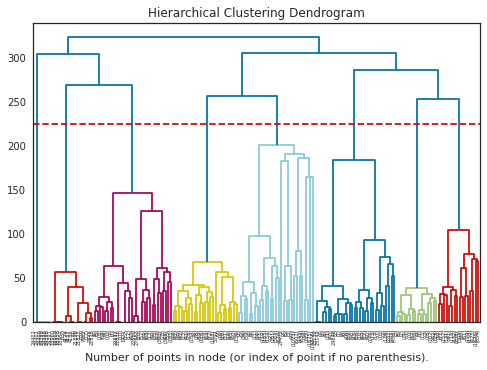

CPU times: user 3.14 s, sys: 384 ms, total: 3.53 s
Wall time: 2.99 s


In [22]:
%%time
title = "Hierarchical Clustering Dendrogram"
xlabel = "Number of points in node (or index of point if no parenthesis)."
# plot the top seven levels of the dendrogram
plot_dendrogram(ac30k, title=title, xlabel=xlabel, y=225, truncate_mode="level", p=7)

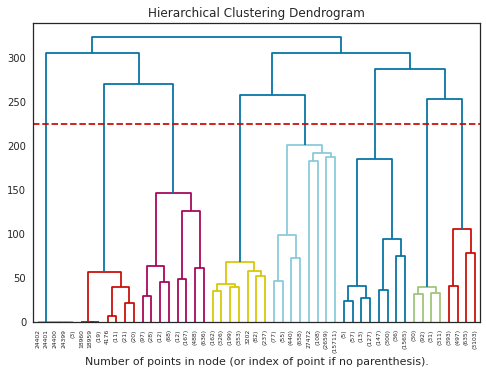

CPU times: user 1.35 s, sys: 356 ms, total: 1.71 s
Wall time: 1.17 s


In [23]:
%%time
title = "Hierarchical Clustering Dendrogram"
xlabel = "Number of points in node (or index of point if no parenthesis)."
# plot the top five levels of the dendrogram
plot_dendrogram(ac30k, title=title, xlabel=xlabel, y=225, truncate_mode="level", p=5)

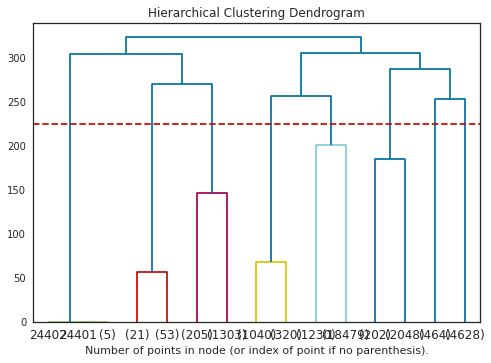

CPU times: user 424 ms, sys: 172 ms, total: 596 ms
Wall time: 309 ms


In [24]:
%%time
title = "Hierarchical Clustering Dendrogram"
xlabel = "Number of points in node (or index of point if no parenthesis)."
# plot the top three levels of the dendrogram
plot_dendrogram(ac30k, title=title, xlabel=xlabel, y=225, truncate_mode="level", p=3)

#### PCA

In [18]:
# initialize pca
pca = PCA(n_components=0.99)
# fit data
x_pca = pca.fit_transform(df_ss)

In [19]:
%%time
# setting distance_threshold=0 ensures we compute the full tree.
ac30k_pca = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
ac30k_pca = ac30k_pca.fit(x_pca[:30000])

CPU times: user 40.4 s, sys: 1.54 s, total: 41.9 s
Wall time: 41.6 s


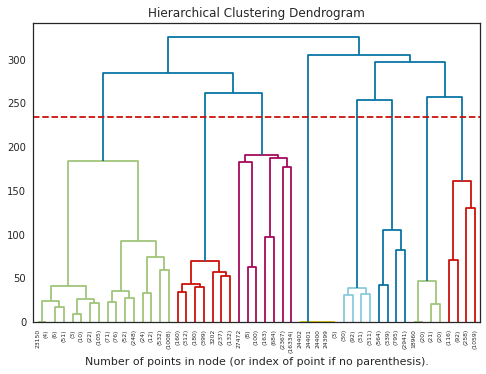

CPU times: user 1.5 s, sys: 345 ms, total: 1.85 s
Wall time: 1.31 s


In [25]:
%%time
title = "Hierarchical Clustering Dendrogram"
xlabel = "Number of points in node (or index of point if no parenthesis)."
# plot the top five levels of the dendrogram
plot_dendrogram(ac30k_pca, title=title, xlabel=xlabel, y=235, truncate_mode="level", p=5)

### Kmeans

In [12]:
%%time
# fitting K-means models
w = []
db_score = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(df_ss)
    # get inertia for Elbow Plot
    w.append(km.inertia_)
    km= km.predict(df_ss)
    # calculate Davies Bouldin score
    db_score.append(davies_bouldin_score(df_ss, km))

CPU times: user 10min 40s, sys: 2min 14s, total: 12min 55s
Wall time: 1min 39s


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


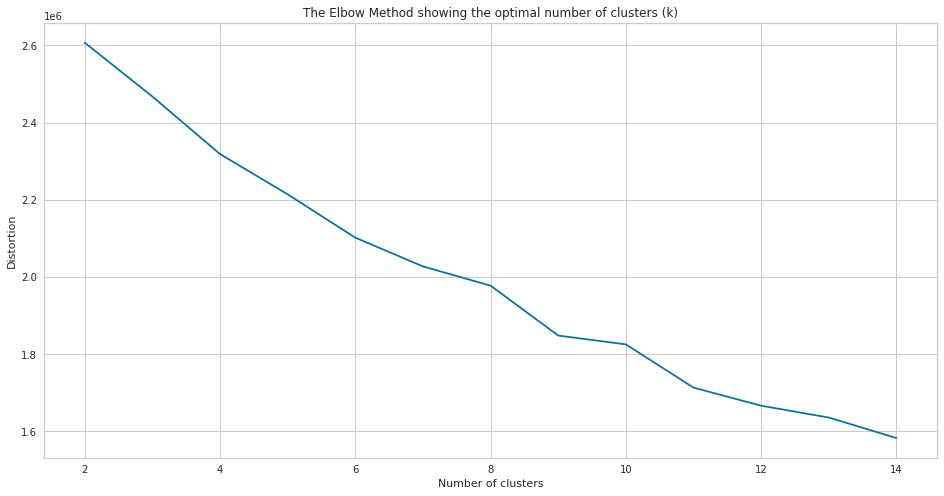

In [13]:
# create Elbow Plot
plt.figure(figsize=(16,8))
plt.plot(K, w)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal number of clusters (k)')

plt.show()

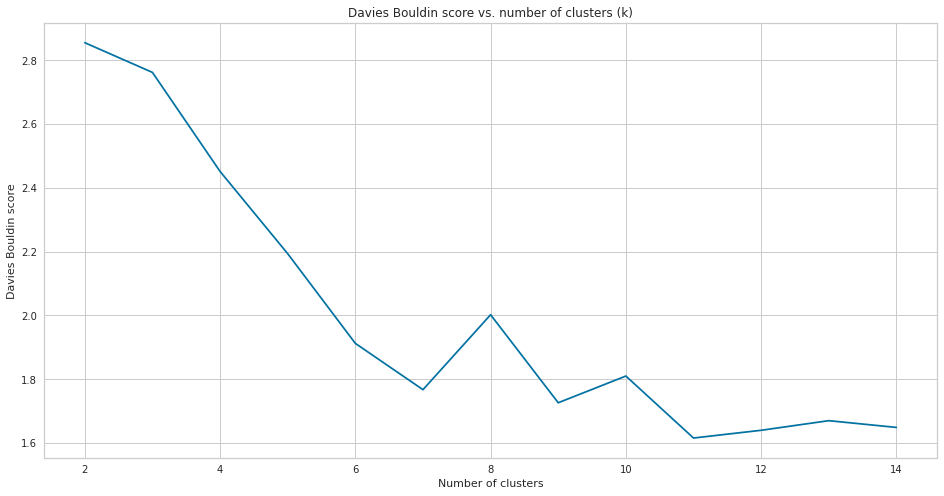

CPU times: user 897 ms, sys: 70 ms, total: 967 ms
Wall time: 338 ms


In [14]:
%%time
# plot Davies Bouldin score
plt.figure(figsize=(16,8))
plt.plot(K, db_score)
plt.xlabel('Number of clusters')
plt.ylabel('Davies Bouldin score')
plt.title('Davies Bouldin score vs. number of clusters (k)')

plt.show()

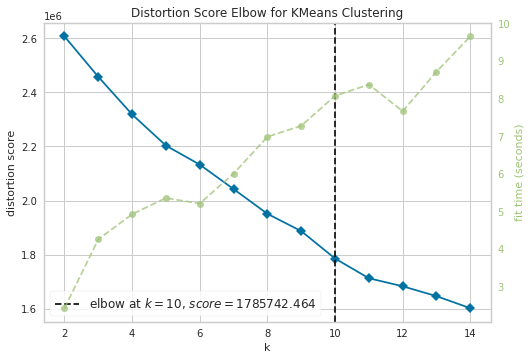

CPU times: user 9min 22s, sys: 2min 7s, total: 11min 30s
Wall time: 1min 28s


In [17]:
%%time
# Instantiate the clustering model and visualizer
km = KMeans()
visualizer_km = KElbowVisualizer(km, k=(2,15))

visualizer_km.fit(df_ss)    # Fit the data to the visualizer
visualizer_km.poof()        # Draw/show/poof the data

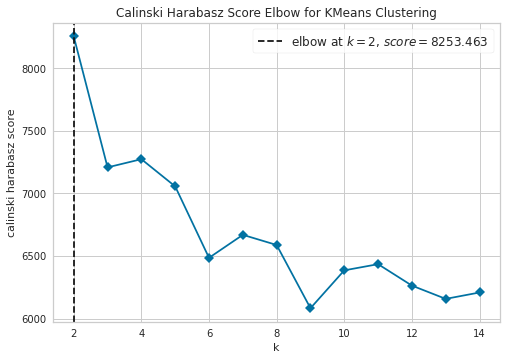

CPU times: user 8min 46s, sys: 1min 50s, total: 10min 37s
Wall time: 1min 21s


In [18]:
%%time
# Instantiate the clustering model and visualizer
visualizer_km_calinski = KElbowVisualizer(
    km, k=(2, 15), metric="calinski_harabasz", timings=False
)

visualizer_km_calinski.fit(df_ss)  # Fit the data to the visualizer
visualizer_km_calinski.poof()      # Draw/show/poof the data

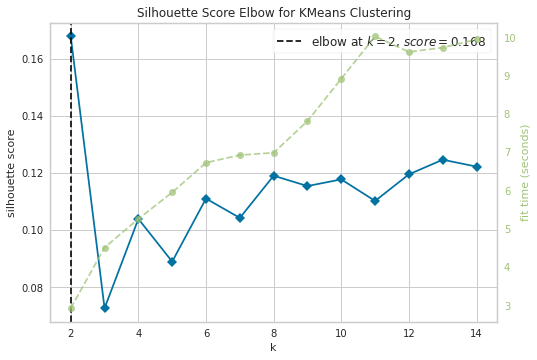

CPU times: user 1h 54min 29s, sys: 1h 57min 48s, total: 3h 52min 17s
Wall time: 57min 45s


In [19]:
%%time
# Instantiate the clustering model and visualizer
visualizer_km_silhouette = KElbowVisualizer(km, k=(2, 15), metric="silhouette")

visualizer_km_silhouette.fit(df_ss)  # Fit the data to the visualizer
visualizer_km_silhouette.poof()  # Draw/show/poof the data

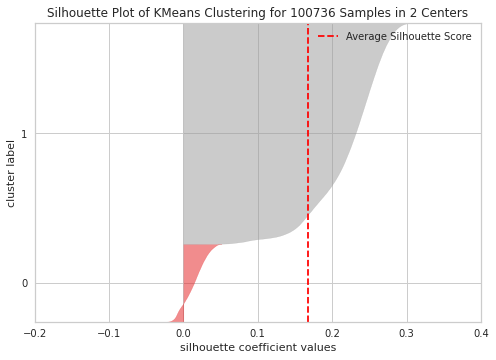

CPU times: user 15min 59s, sys: 17min 30s, total: 33min 29s
Wall time: 8min 26s


In [20]:
%%time
# Instantiate the clustering model and visualizer 
# model = 
visualizer = SilhouetteVisualizer(KMeans(2))

visualizer.fit(df_ss)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

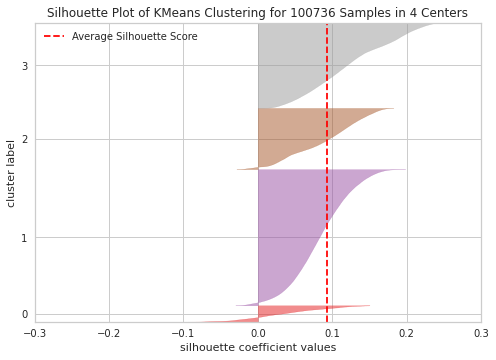

CPU times: user 16min 5s, sys: 17min 39s, total: 33min 44s
Wall time: 8min 31s


In [21]:
%%time
# Instantiate the clustering model and visualizer 
# model = 
visualizer = SilhouetteVisualizer(KMeans(4))

visualizer.fit(df_ss)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

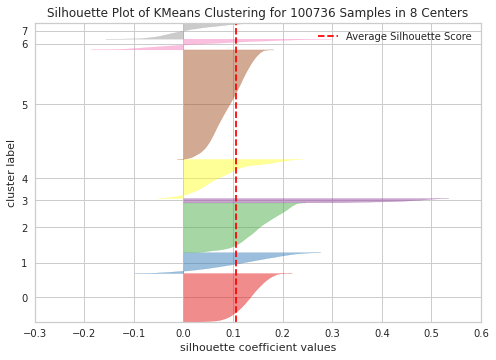

CPU times: user 16min 21s, sys: 17min 41s, total: 34min 3s
Wall time: 8min 36s


In [22]:
%%time
# Instantiate the clustering model and visualizer 
# model = 
visualizer = SilhouetteVisualizer(KMeans(8))

visualizer.fit(df_ss)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

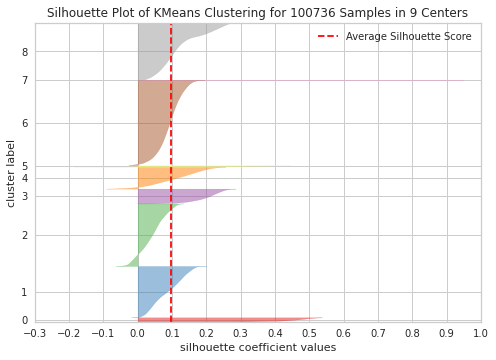

CPU times: user 16min 59s, sys: 17min 48s, total: 34min 48s
Wall time: 8min 59s


In [23]:
%%time
# Instantiate the clustering model and visualizer 
# model = 
visualizer = SilhouetteVisualizer(KMeans(9))

visualizer.fit(df_ss)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

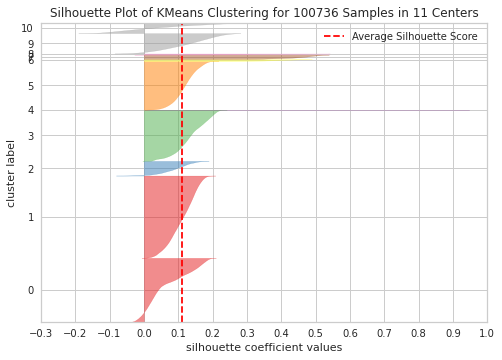

CPU times: user 16min 40s, sys: 17min 45s, total: 34min 25s
Wall time: 8min 48s


In [24]:
%%time
# Instantiate the clustering model and visualizer 
# model = 
visualizer = SilhouetteVisualizer(KMeans(11))

visualizer.fit(df_ss)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

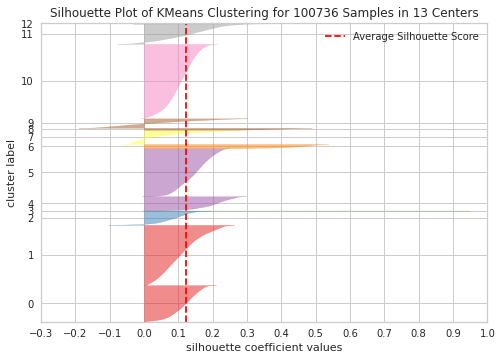

CPU times: user 16min 54s, sys: 17min 58s, total: 34min 52s
Wall time: 8min 53s


In [25]:
%%time
# Instantiate the clustering model and visualizer 
# model = 
visualizer = SilhouetteVisualizer(KMeans(13))

visualizer.fit(df_ss)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

### DBSCAN

#### Cherche la Valeur EPS

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


CPU times: user 9min 2s, sys: 10min 43s, total: 19min 45s
Wall time: 6min 34s


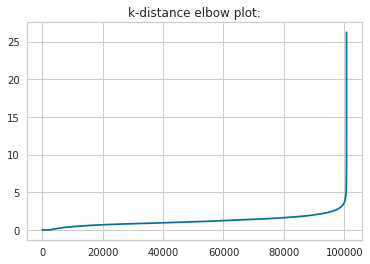

In [8]:
%%time
# find the eps using NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=29)
neighbors.fit(df_ss)
distances, indices = neighbors.kneighbors(df_ss)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.title('k-distance elbow plot:')
plt.plot(distances)

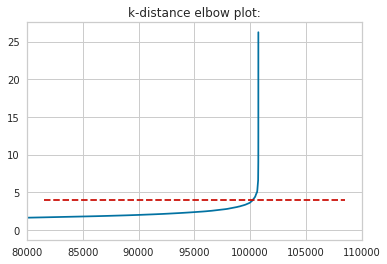

In [ ]:
# zoom in plot
plt.title('k-distance elbow plot:')

plt.plot(distances)
plt.axhline(y=4, color='r', linestyle='--',xmin=0.05,xmax=0.95)
plt.xlim(80000, 110000)

plt.show();

#### DBSCAN

In [8]:
%%time
# instantiate and fit DBSCAN
db = DBSCAN(eps=4, min_samples=29)
db.fit(df_ss)

# crate sample mask and get labels
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# calculate number of clusters
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

CPU times: user 1min 54s, sys: 1min 9s, total: 3min 4s
Wall time: 1min 31s


9

In [9]:
# calculate number of noise data points
n_noise_ = list(labels).count(-1)
n_noise_

1914

## Visualisation

### TSNE

#### iter = 2000

In [10]:
%%time
df_ss_tsne = pd.DataFrame()
tsne = TSNE(n_components=2, perplexity=50, n_iter=2000, init="pca")
tsne = tsne.fit_transform(df_ss)
df_ss_tsne['dim_x'] = tsne[:,0]
df_ss_tsne['dim_y'] = tsne[:,1]

CPU times: user 5h 23min 44s, sys: 13min 12s, total: 5h 36min 57s
Wall time: 46min 56s


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


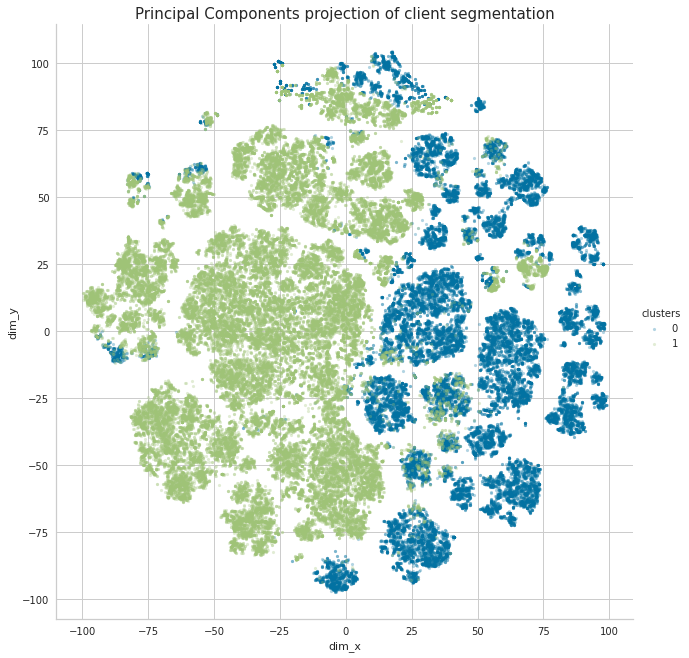

CPU times: user 24.4 s, sys: 4.88 s, total: 29.2 s
Wall time: 5.64 s


In [12]:
%%time
# k = 2
test = KMeans(n_clusters=2)
test = test.fit(df_ss)
df_ss_tsne['clusters'] = test.labels_
plot_clusters(
    x='dim_x',
    y='dim_y',
    data=df_ss_tsne,
    hue='clusters',
    title="Principal Components projection of client segmentation",
)

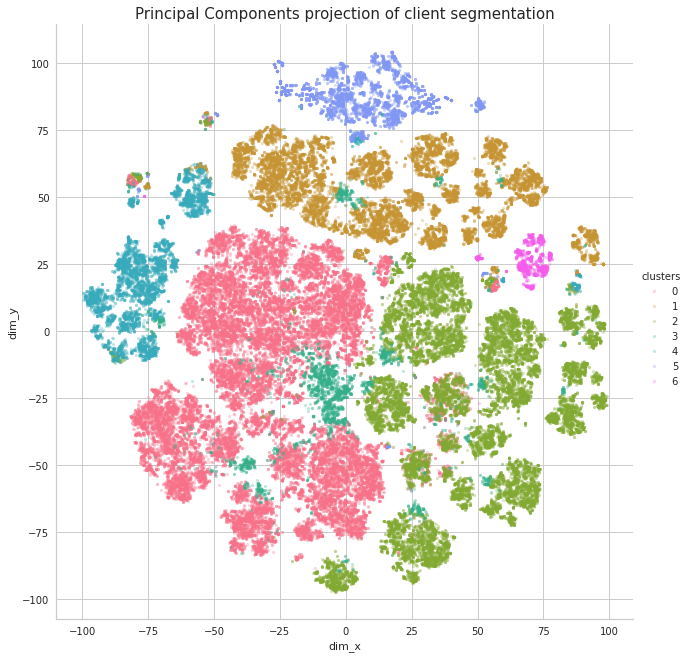

CPU times: user 37.8 s, sys: 8.63 s, total: 46.5 s
Wall time: 6.76 s


In [13]:
%%time
# k = 7
test = KMeans(n_clusters=7)
test = test.fit(df_ss)
df_ss_tsne['clusters'] = test.labels_
plot_clusters(
    x='dim_x',
    y='dim_y',
    data=df_ss_tsne,
    hue='clusters',
    title="Principal Components projection of client segmentation",
)

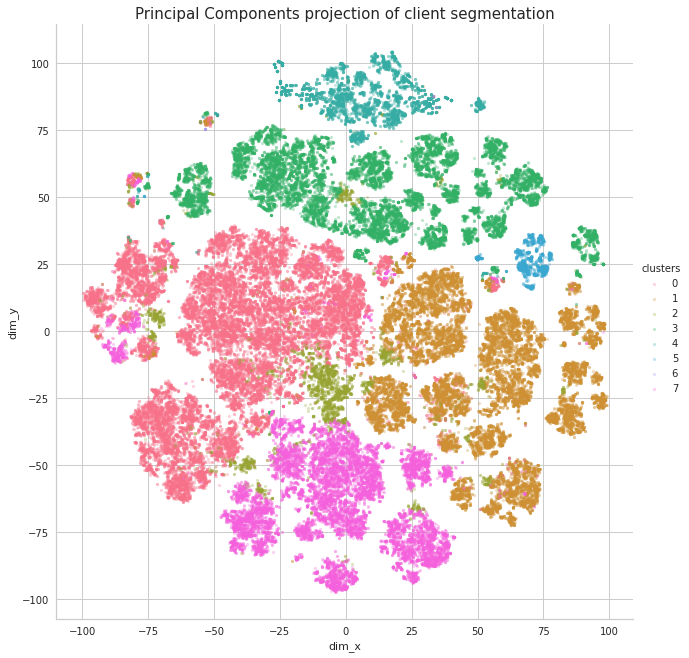

CPU times: user 41.8 s, sys: 9.53 s, total: 51.4 s
Wall time: 7.24 s


In [14]:
%%time
# k = 8
test = KMeans(n_clusters=8)
test = test.fit(df_ss)
df_ss_tsne['clusters'] = test.labels_
plot_clusters(
    x='dim_x',
    y='dim_y',
    data=df_ss_tsne,
    hue='clusters',
    title="Principal Components projection of client segmentation",
)

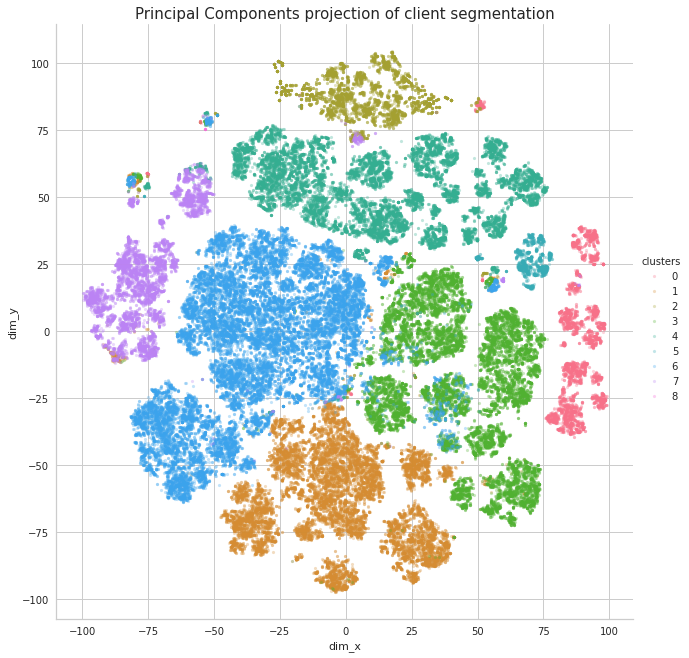

CPU times: user 47.2 s, sys: 11.1 s, total: 58.3 s
Wall time: 10.6 s


In [15]:
%%time
# k = 9
test = KMeans(n_clusters=9)
test = test.fit(df_ss)
df_ss_tsne['clusters'] = test.labels_
plot_clusters(
    x='dim_x',
    y='dim_y',
    data=df_ss_tsne,
    hue='clusters',
    title="Principal Components projection of client segmentation",
)

#### iter = 3000

In [17]:
%%time
df_ss_tsne_3k = pd.DataFrame()
tsne_3k = TSNE(n_components=2, perplexity=50, n_iter=3000, init="pca")
tsne_3k = tsne_3k.fit_transform(df_ss)
df_ss_tsne_3k['dim_x'] = tsne_3k[:,0]
df_ss_tsne_3k['dim_y'] = tsne_3k[:,1]

CPU times: user 4h 33min 12s, sys: 12min 20s, total: 4h 45min 32s
Wall time: 39min 31s


In [18]:
def plot_tsne(x, y, data, hue, title=None):
    sns.lmplot(
        x=x,
        y=y,
        data=data,
        legend=True,
        height=9,
        hue=hue,
        scatter_kws={"s": 10, "alpha": 0.3},
        fit_reg=False,
    )

    if title is not None:
        plt.title(title, fontdict={'fontsize': 15})
    plt.show()

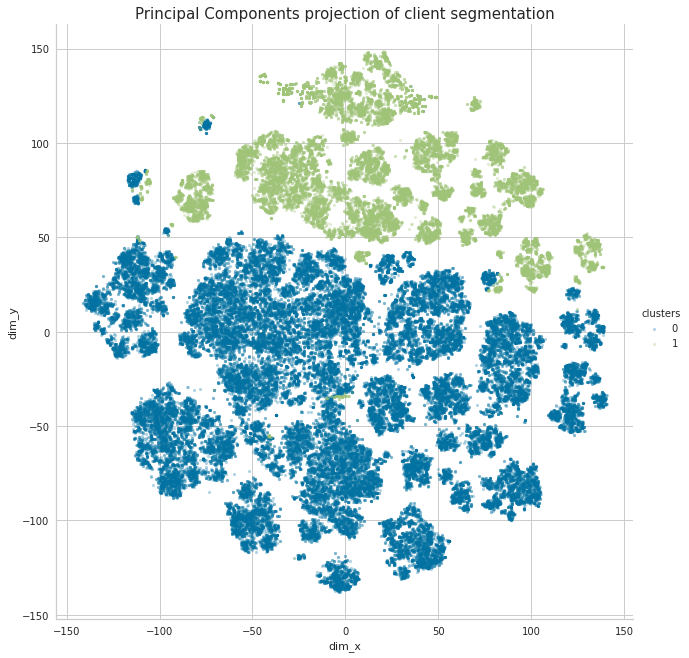

CPU times: user 18.8 s, sys: 4.45 s, total: 23.2 s
Wall time: 4.04 s


In [19]:
%%time
# k = 2
test = KMeans(n_clusters=2)
test = test.fit(df_ss)
df_ss_tsne_3k['clusters'] = test.labels_
plot_clusters(
    x='dim_x',
    y='dim_y',
    data=df_ss_tsne_3k,
    hue='clusters',
    title="Principal Components projection of client segmentation",
)

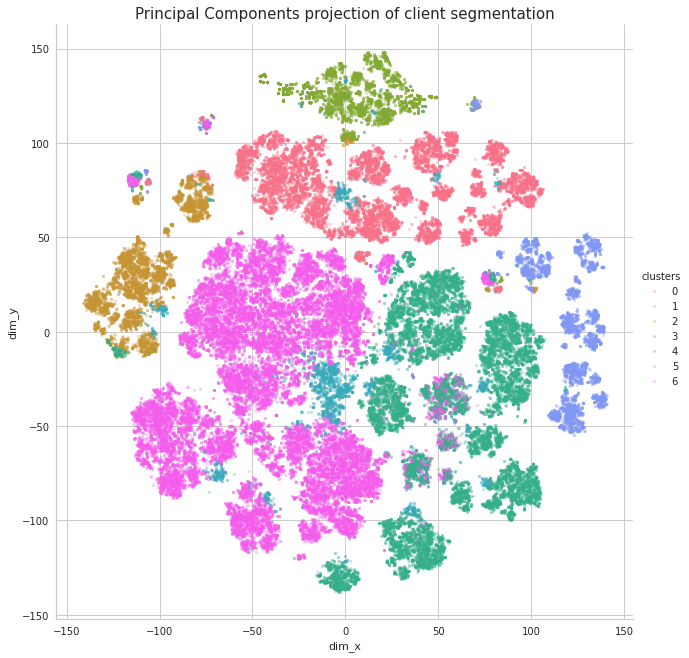

CPU times: user 28 s, sys: 6.08 s, total: 34.1 s
Wall time: 5.02 s


In [20]:
%%time
# k = 7
test = KMeans(n_clusters=7)
test = test.fit(df_ss)
df_ss_tsne_3k['clusters'] = test.labels_
plot_clusters(
    x='dim_x',
    y='dim_y',
    data=df_ss_tsne_3k,
    hue='clusters',
    title="Principal Components projection of client segmentation",
)

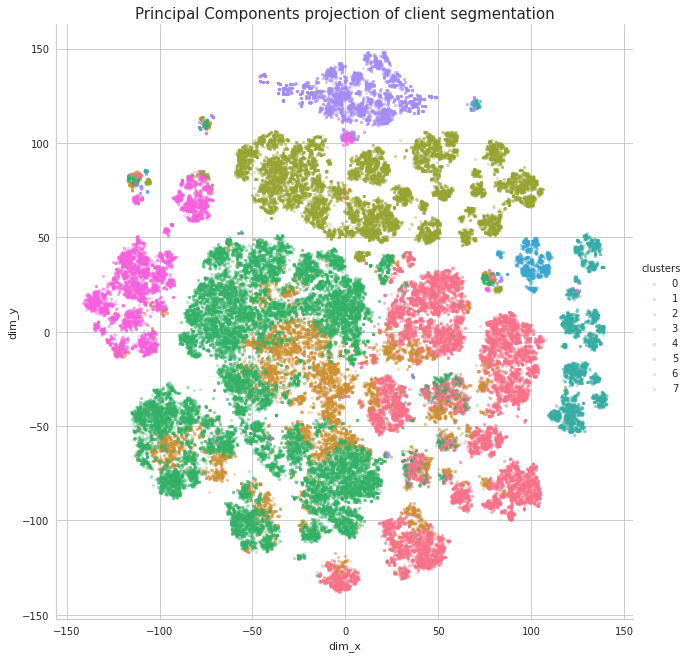

CPU times: user 33.6 s, sys: 8.37 s, total: 42 s
Wall time: 6.13 s


In [21]:
%%time
# k = 8
test = KMeans(n_clusters=8)
test = test.fit(df_ss)
df_ss_tsne_3k['clusters'] = test.labels_
plot_clusters(
    x='dim_x',
    y='dim_y',
    data=df_ss_tsne_3k,
    hue='clusters',
    title="Principal Components projection of client segmentation",
)

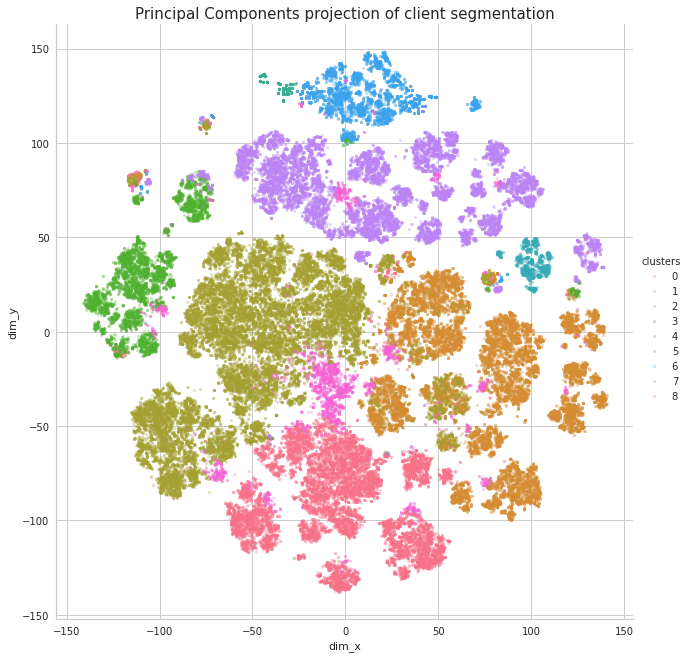

CPU times: user 33.5 s, sys: 8.97 s, total: 42.4 s
Wall time: 6.16 s


In [22]:
%%time
# k = 9
test = KMeans(n_clusters=9)
test = test.fit(df_ss)
df_ss_tsne_3k['clusters'] = test.labels_
plot_clusters(
    x='dim_x',
    y='dim_y',
    data=df_ss_tsne_3k,
    hue='clusters',
    title="Principal Components projection of client segmentation",
)

### UMAP

In [10]:
%%time
clusterable_embedding = umap.UMAP(
    n_neighbors=29,
    min_dist=0.0,
    n_components=2,
    random_state=42,
)
clusterable_embedding = clusterable_embedding.fit_transform(df_ss)

CPU times: user 18min 58s, sys: 8min 7s, total: 27min 6s
Wall time: 5min 56s


In [13]:
df_ss_umap = pd.DataFrame()
df_ss_umap['dim_x'] = clusterable_embedding[:, 0]
df_ss_umap['dim_y'] = clusterable_embedding[:, 1]

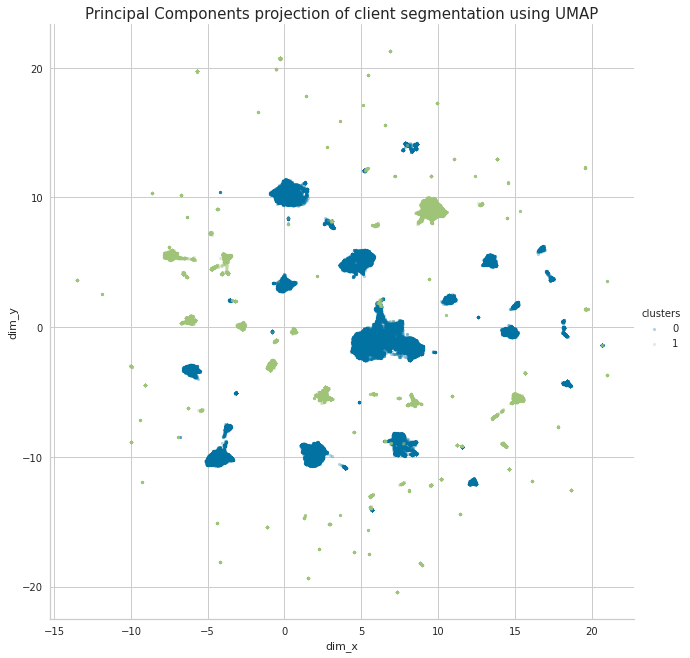

CPU times: user 16.5 s, sys: 3.17 s, total: 19.7 s
Wall time: 2.62 s


In [19]:
%%time
# k = 2
test = KMeans(n_clusters=2)
test = test.fit(df_ss)
df_ss_umap['clusters'] = test.labels_
plot_clusters(
    x='dim_x',
    y='dim_y',
    data=df_ss_umap,
    hue='clusters',
    title="Principal Components projection of client segmentation using UMAP",
)

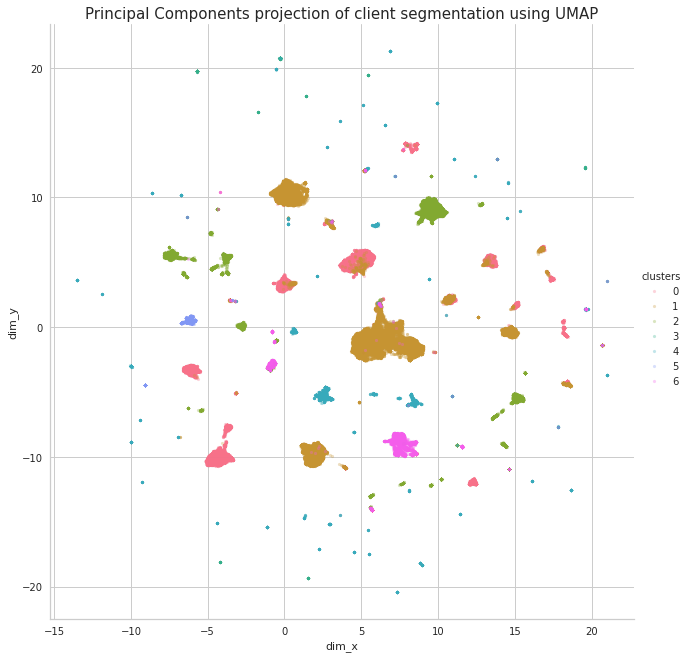

CPU times: user 35.3 s, sys: 6.01 s, total: 41.4 s
Wall time: 5.75 s


In [30]:
%%time
# k = 7
test = KMeans(n_clusters=7)
test = test.fit(df_ss)
df_ss_umap['clusters'] = test.labels_
plot_clusters(
    x='dim_x',
    y='dim_y',
    data=df_ss_umap,
    hue='clusters',
    title="Principal Components projection of client segmentation using UMAP",
)

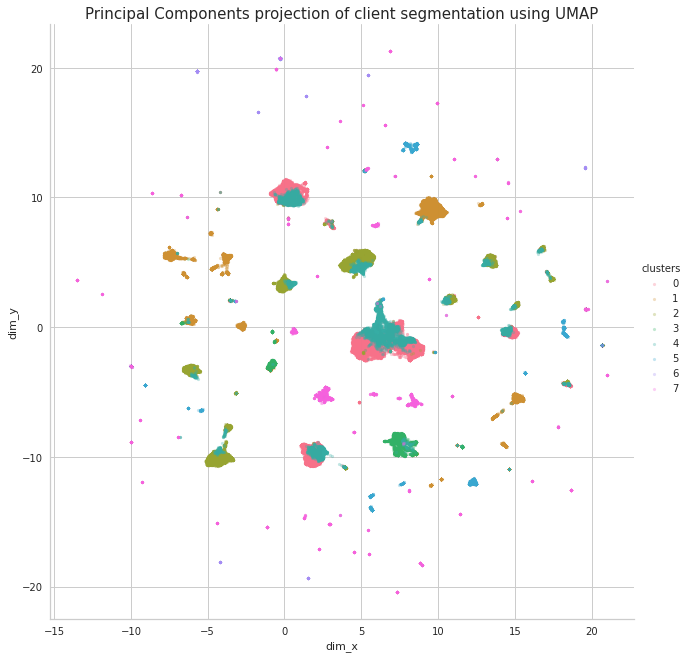

CPU times: user 39.6 s, sys: 6.55 s, total: 46.1 s
Wall time: 6.45 s


In [31]:
%%time
# k = 8
test = KMeans(n_clusters=8)
test = test.fit(df_ss)
df_ss_umap['clusters'] = test.labels_
plot_clusters(
    x='dim_x',
    y='dim_y',
    data=df_ss_umap,
    hue='clusters',
    title="Principal Components projection of client segmentation using UMAP",
)

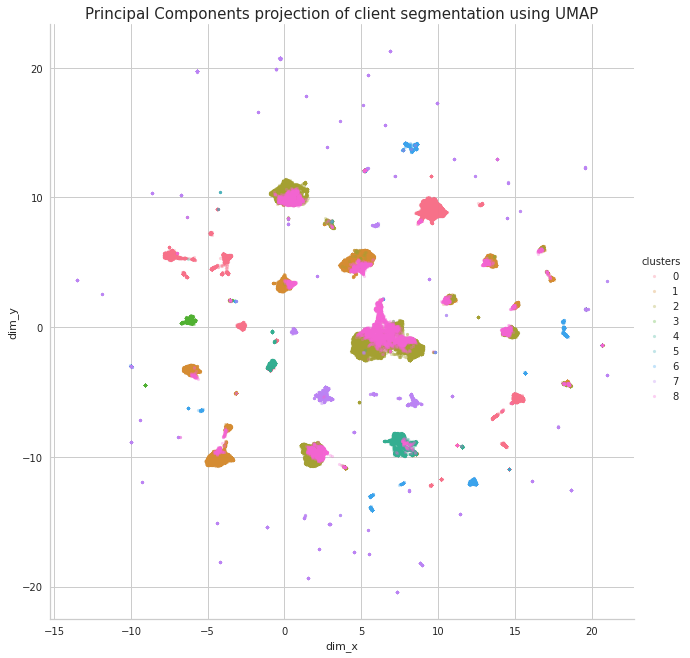

CPU times: user 45.1 s, sys: 8.05 s, total: 53.2 s
Wall time: 7.74 s


In [29]:
%%time
# k = 9
test = KMeans(n_clusters=9)
test = test.fit(df_ss)
df_ss_umap['clusters'] = test.labels_
plot_clusters(
    x='dim_x',
    y='dim_y',
    data=df_ss_umap,
    hue='clusters',
    title="Principal Components projection of client segmentation using UMAP",
)

## Anaylse des Clusters

### 7 Clusters

In [192]:
%%time
# k = 7
km7_ss = KMeans(n_clusters=7)
km7_ss = km7_ss.fit(df_ss)
df_ss_umap['clusters'] = km7_ss.labels_

CPU times: user 32.7 s, sys: 6.27 s, total: 39 s
Wall time: 5.54 s


In [194]:
df_analyse_ss = df_ss.copy()
df_analyse_ss['clusters'] = km7_ss.labels_

In [196]:
clusters_ss = {}
for cluster in range(7):
    clusters_ss[cluster] = list(
        df_analyse_ss[df_analyse_ss.clusters == cluster].iloc[:, :-1].mean().values
    )
    clusters_ss[cluster] = [*clusters_ss[cluster], clusters_ss[cluster][0]]

In [204]:
%%time
plot_radar(clusters_ss[0], title='Client Segmentation - cluster 0')

CPU times: user 9 ms, sys: 0 ns, total: 9 ms
Wall time: 8.49 ms


**Cluster 0**

Debit card users

In [205]:
%%time
plot_radar(clusters_ss[1], title='Client Segmentation - cluster 1')

CPU times: user 8.96 ms, sys: 0 ns, total: 8.96 ms
Wall time: 8.47 ms


**Cluster 1**<br>
National buyers, many installments (like to economiser or plan ahead), buy high value items, big size items <br>
Deliver before estimated time <br>
weekend and holiday buyers too

In [209]:
%%time
plot_radar(clusters_ss[2], title='Client Segmentation - cluster 2')

CPU times: user 7.97 ms, sys: 2.29 ms, total: 10.3 ms
Wall time: 9.36 ms


**Cluster 2**<br>
Regional buyers and credit card users, need it to be before the shipping promise

In [211]:
%%time
plot_radar(clusters_ss[3], title='Client Segmentation - cluster 3')

CPU times: user 9.37 ms, sys: 0 ns, total: 9.37 ms
Wall time: 8.64 ms


**Cluster 3**<br>
Holiday and weekend buyers. Buy in advance. don't mind to wait<br>
Not happy buyers

In [212]:
%%time
plot_radar(clusters_ss[4], title='Client Segmentation - cluster 4')

CPU times: user 9.51 ms, sys: 0 ns, total: 9.51 ms
Wall time: 9.02 ms


**Cluster 4**<br>
Careful and economical buyers: <br>
- bindle buyers
- study well the product (long product name)

In [206]:
%%time
plot_radar(clusters_ss[5], title='Client Segmentation - cluster 5')

CPU times: user 19.8 ms, sys: 3.67 ms, total: 23.5 ms
Wall time: 22.6 ms


**Cluster 5**<br>
Boleto users


In [207]:
%%time
plot_radar(clusters_ss[6], title='Client Segmentation - cluster 6')

CPU times: user 11.1 ms, sys: 544 µs, total: 11.6 ms
Wall time: 10.7 ms


**Cluster 6**<br>
Neighbor shopppers

# MinMax Scaler

In [32]:
mmscaler = MinMaxScaler()
df_mmss = pd.DataFrame(mmscaler.fit_transform(df), columns=df.columns)
df_mmss.describe()

product_name_length  product_description_length  product_photos_qty  \
count        100736.000000               100736.000000       100736.000000   
mean              0.634032                    0.195607            0.110854   
std               0.150975                    0.164290            0.087617   
min               0.000000                    0.000000            0.000000   
25%               0.552632                    0.085421            0.050000   
50%               0.684211                    0.150050            0.050000   
75%               0.750000                    0.246994            0.150000   
max               1.000000                    1.000000            1.000000   

       payment_installments  number_of_reviews   review_score      price_log  \
count         100736.000000      100736.000000  100736.000000  100736.000000   
mean               0.118820           0.332979       0.825364       0.503199   
std                0.111852           0.037174       0.264847       0.102785   
min                0.000000           0.000000       0.000000       0.000000   
25%                0.041667           0.333333       0.800000       0.432645   
50%                0.041667           0.333333       1.000000       0.504809   
75%                0.166667           0.333333       1.000000       0.568361   
max                1.000000           1.000000       1.000000       1.000000   

            distance  freight_price_ratio  delivery_time_days  ...  \
count  100736.000000        100736.000000       100736.000000  ...   
mean        0.062781             0.680102            0.057925  ...   
std         0.073226             0.016747            0.045721  ...   
min         0.000000             0.000000            0.000000  ...   
25%         0.005910             0.671405            0.028708  ...   
50%         0.042743             0.676322            0.047847  ...   
75%         0.087483             0.683018            0.071770  ...   
max         1.000000             1.000000            1.000000  ...   

           same_city     same_state        weekend        holiday  \
count  100736.000000  100736.000000  100736.000000  100736.000000   
mean        0.051044       0.359147       0.229372       0.702837   
std         0.220089       0.479753       0.420431       0.457011   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       1.000000   
75%         0.000000       1.000000       0.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   

        order_status  product_category_label  payment_type_boleto  \
count  100736.000000           100736.000000        100736.000000   
mean        0.999940                0.218006             0.190468   
std         0.007717                0.230389             0.392672   
min         0.000000                0.000000             0.000000   
25%         1.000000                0.052632             0.000000   
50%         1.000000                0.157895             0.000000   
75%         1.000000                0.368421             0.000000   
max         1.000000                1.000000             1.000000   

       payment_type_credit_card  payment_type_debit_card  payment_type_voucher  
count             100736.000000            100736.000000         100736.000000  
mean                   0.740282                 0.014742              0.054509  
std                    0.438482                 0.120517              0.227020  
min                    0.000000                 0.000000              0.000000  
25%                    0.000000                 0.000000              0.000000  
50%                    1.000000                 0.000000              0.000000  
75%                    1.000000                 0.000000              0.000000  
max                    1.000000                 1.000000    

## Clustering
### Clustering Hiérarchique

In [33]:
df_mmss.sample(5)

product_name_length  product_description_length  product_photos_qty  \
91900             0.776316                    0.079910                0.20   
25380             0.750000                    0.090180                0.15   
32986             0.789474                    0.132265                0.10   
63475             0.723684                    0.095691                0.25   
46281             0.697368                    0.082665                0.05   

       payment_installments  number_of_reviews  review_score  price_log  \
91900              0.041667           0.333333           0.8   0.503390   
25380              0.041667           0.333333           0.8   0.434170   
32986              0.041667           0.333333           1.0   0.619894   
63475              0.041667           0.333333           1.0   0.529946   
46281              0.416667           0.333333           1.0   0.607716   

       distance  freight_price_ratio  delivery_time_days  ...  same_city  \
91900  0.015693             0.663354            0.019139  ...        0.0   
25380  0.094022             0.676995            0.062201  ...        0.0   
32986  0.043063             0.671151            0.038278  ...        0.0   
63475  0.023215             0.670827            0.052632  ...        0.0   
46281  0.001360             0.675049            0.033493  ...        0.0   

       same_state  weekend  holiday  order_status  product_category_label  \
91900         1.0      0.0      0.0           1.0                0.263158   
25380         0.0      0.0      1.0           1.0                0.578947   
32986         0.0      0.0      0.0           1.0                0.157895   
63475         1.0      1.0      1.0           1.0                0.473684   
46281         0.0      0.0      1.0           1.0                0.421053   

       payment_type_boleto  payment_type_credit_card  payment_type_debit_card  \
91900                  0.0                       1.0                      0.0   
25380                  0.0                       1.0                      0.0   
32986                  1.0                       0.0                      0.0   
63475                  1.0                       0.0                      0.0   
46281                  0.0                       1.0                      0.0   

       payment_type_voucher  
91900                   0.0  
25380                   0.0  
32986                   0.0  
63475                   0.0  
46281                   0.0  

[5 rows x 28 columns]

In [7]:
%%time
# setting distance_threshold=0 ensures we compute the full tree.
ac_40k_mmss = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
ac_40k_mmss = ac_40k_mmss.fit(df_mmss.sample(40000))

CPU times: user 1min 8s, sys: 2.48 s, total: 1min 10s
Wall time: 1min 10s


In [ ]:
with open('model/agglo_cluster_40k_mmss.pkl', 'wb') as f:
    pickle.dump(ac_40k_mmss, f)

In [ ]:
# with open('model/agglo_cluster_40k_mmss.pkl', 'rb') as f:
#     pickle.load(ac_40k_mmss, f)

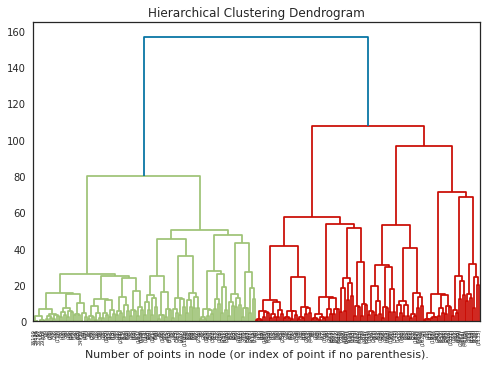

CPU times: user 4.66 s, sys: 536 ms, total: 5.2 s
Wall time: 4.66 s


In [20]:
%%time
title = "Hierarchical Clustering Dendrogram"
xlabel = "Number of points in node (or index of point if no parenthesis)."
# plot the top seven levels of the dendrogram
plot_dendrogram(ac_40k_mmss, title=title, xlabel=xlabel, y=250, truncate_mode="level", p=7)

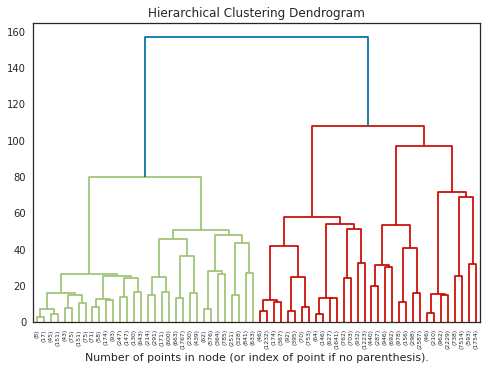

CPU times: user 1.59 s, sys: 460 ms, total: 2.05 s
Wall time: 1.51 s


In [21]:
%%time
title = "Hierarchical Clustering Dendrogram"
xlabel = "Number of points in node (or index of point if no parenthesis)."
# plot the top five levels of the dendrogram
plot_dendrogram(ac_40k_mmss, title=title, xlabel=xlabel, y=250, truncate_mode="level", p=5)

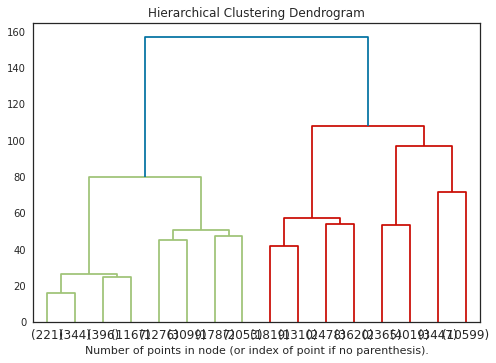

CPU times: user 658 ms, sys: 172 ms, total: 830 ms
Wall time: 462 ms


In [22]:
%%time
title = "Hierarchical Clustering Dendrogram"
xlabel = "Number of points in node (or index of point if no parenthesis)."
# plot the top three levels of the dendrogram
plot_dendrogram(ac_40k_mmss, title=title, xlabel=xlabel, y=240, truncate_mode="level", p=3)

In [11]:
%%time
# setting distance_threshold=0 ensures we compute the full tree.
ac30k_mmss = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
ac30k_mmss = ac30k_mmss.fit(df_mmss[:30000])

CPU times: user 39.8 s, sys: 1.57 s, total: 41.4 s
Wall time: 41.3 s


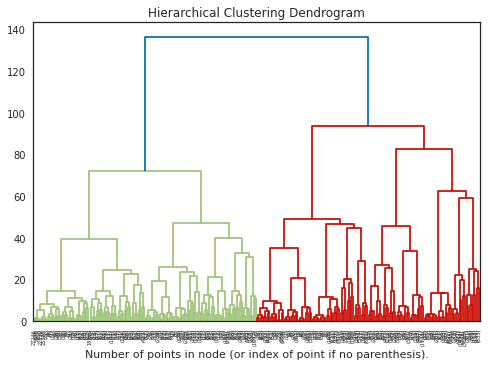

CPU times: user 4.73 s, sys: 468 ms, total: 5.2 s
Wall time: 4.66 s


In [23]:
%%time
title = "Hierarchical Clustering Dendrogram"
xlabel = "Number of points in node (or index of point if no parenthesis)."
# plot the top seven levels of the dendrogram
plot_dendrogram(ac30k_mmss, title=title, xlabel=xlabel, y=225, truncate_mode="level", p=7)

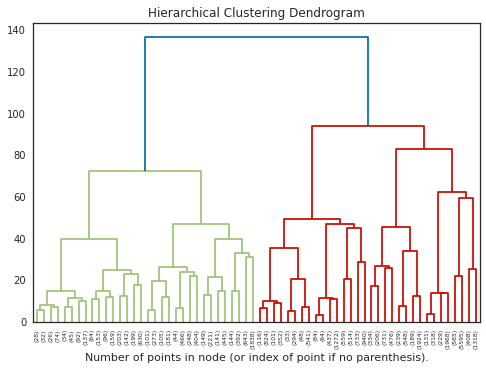

CPU times: user 1.63 s, sys: 368 ms, total: 2 s
Wall time: 1.46 s


In [24]:
%%time
title = "Hierarchical Clustering Dendrogram"
xlabel = "Number of points in node (or index of point if no parenthesis)."
# plot the top five levels of the dendrogram
plot_dendrogram(ac30k_mmss, title=title, xlabel=xlabel, y=225, truncate_mode="level", p=5)

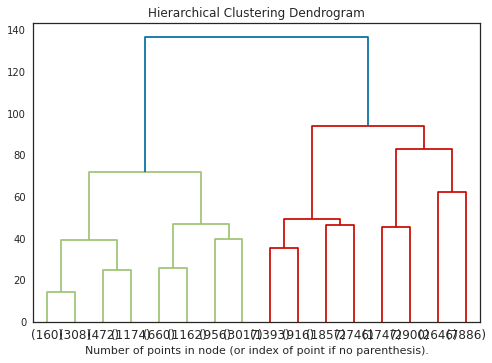

CPU times: user 588 ms, sys: 200 ms, total: 788 ms
Wall time: 423 ms


In [25]:
%%time
title = "Hierarchical Clustering Dendrogram"
xlabel = "Number of points in node (or index of point if no parenthesis)."
# plot the top three levels of the dendrogram
plot_dendrogram(ac30k_mmss, title=title, xlabel=xlabel, y=225, truncate_mode="level", p=3)

#### PCA

In [15]:
# initialize pca
pca = PCA(n_components=0.99)
# fit data
x_pca = pca.fit_transform(df_mmss)

In [16]:
%%time
# setting distance_threshold=0 ensures we compute the full tree.
ac30k_pca_mmss = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
ac30k_pca_mmss = ac30k_pca_mmss.fit(x_pca[:30000])

CPU times: user 36.9 s, sys: 1.57 s, total: 38.5 s
Wall time: 38.1 s


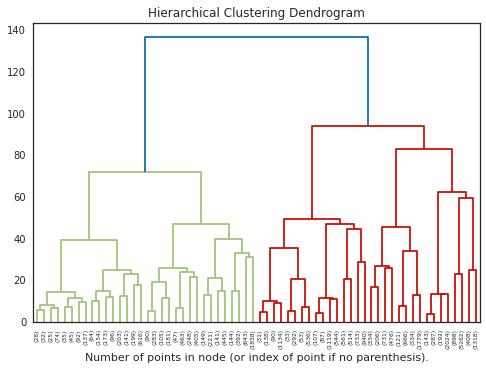

CPU times: user 1.67 s, sys: 365 ms, total: 2.04 s
Wall time: 1.5 s


In [19]:
%%time
title = "Hierarchical Clustering Dendrogram"
xlabel = "Number of points in node (or index of point if no parenthesis)."
# plot the top five levels of the dendrogram
plot_dendrogram(ac30k_pca_mmss, title=title, xlabel=xlabel, y=235, truncate_mode="level", p=5)

### Kmeans

In [18]:
%%time
# fitting K-means models
w = []
db_score = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(df_mmss)
    # get inertia for Elbow Plot
    w.append(km.inertia_)
    km= km.predict(df_mmss)
    # calculate Davies Bouldin score
    db_score.append(davies_bouldin_score(df_mmss, km))

CPU times: user 5min 41s, sys: 1min 50s, total: 7min 31s
Wall time: 57.4 s


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


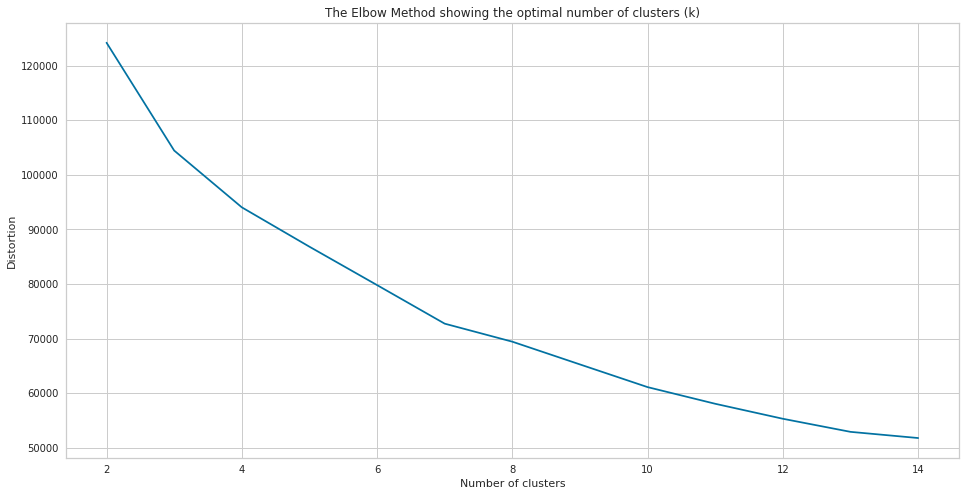

In [19]:
# create Elbow Plot
plt.figure(figsize=(16,8))
plt.plot(K, w)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal number of clusters (k)')

plt.show()

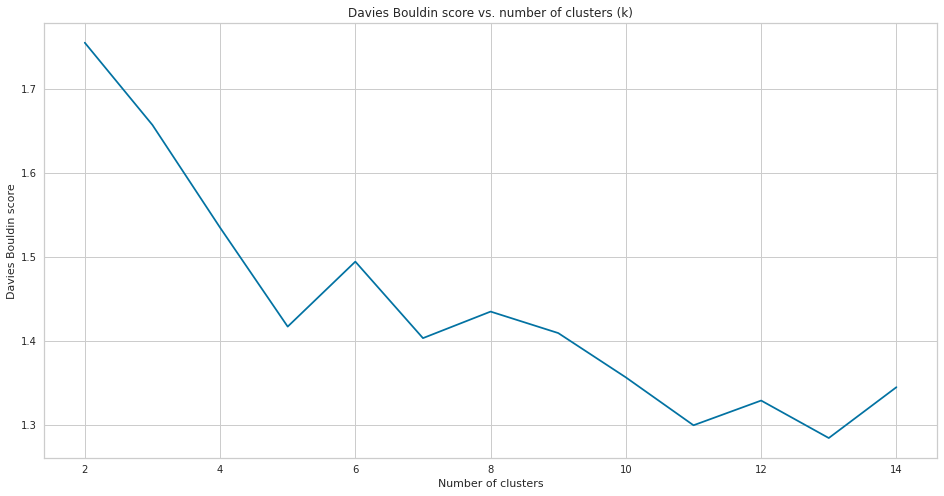

CPU times: user 1.41 s, sys: 51 ms, total: 1.46 s
Wall time: 260 ms


In [20]:
%%time
# plot Davies Bouldin score
plt.figure(figsize=(16,8))
plt.plot(K, db_score)
plt.xlabel('Number of clusters')
plt.ylabel('Davies Bouldin score')
plt.title('Davies Bouldin score vs. number of clusters (k)')

plt.show()

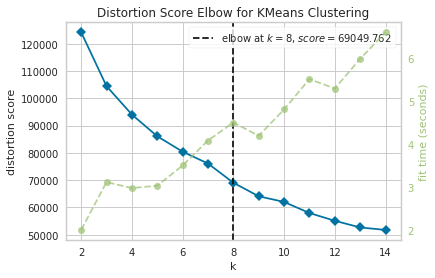

CPU times: user 5min 45s, sys: 1min 55s, total: 7min 41s
Wall time: 58.7 s


In [21]:
%%time
# Instantiate the clustering model and visualizer
km = KMeans()
visualizer_km = KElbowVisualizer(km, k=(2,15))

visualizer_km.fit(df_mmss)    # Fit the data to the visualizer
visualizer_km.poof()    # Draw/show/poof the data

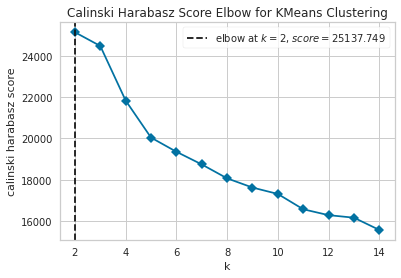

CPU times: user 5min 20s, sys: 1min 41s, total: 7min 1s
Wall time: 53.5 s


In [22]:
%%time
# Instantiate the clustering model and visualizer
visualizer_km_calinski = KElbowVisualizer(
    km, k=(2, 15), metric="calinski_harabasz", timings=False
)

visualizer_km_calinski.fit(df_mmss)  # Fit the data to the visualizer
visualizer_km_calinski.poof()  # Draw/show/poof the data

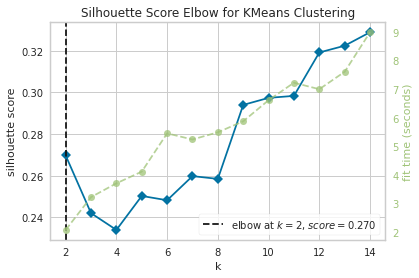

CPU times: user 1h 55min 57s, sys: 1h 51min 1s, total: 3h 46min 59s
Wall time: 55min 37s


In [23]:
%%time
# Instantiate the clustering model and visualizer
visualizer_km_silhouette = KElbowVisualizer(km, k=(2, 15), metric="silhouette")

visualizer_km_silhouette.fit(df_mmss)  # Fit the data to the visualizer
visualizer_km_silhouette.poof()  # Draw/show/poof the data

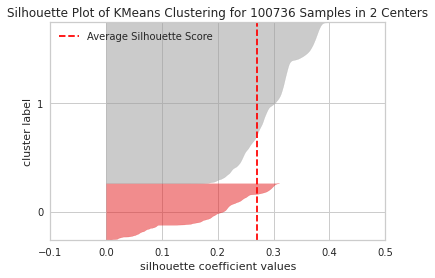

CPU times: user 17min 40s, sys: 17min 28s, total: 35min 8s
Wall time: 8min 55s


In [24]:
%%time
# Instantiate the clustering model and visualizer 
# model = 
visualizer = SilhouetteVisualizer(KMeans(2))

visualizer.fit(df_mmss)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

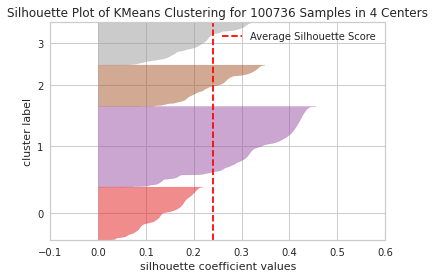

CPU times: user 17min 1s, sys: 17min 24s, total: 34min 26s
Wall time: 8min 40s


In [25]:
%%time
# Instantiate the clustering model and visualizer 
# model = 
visualizer = SilhouetteVisualizer(KMeans(4))

visualizer.fit(df_mmss)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

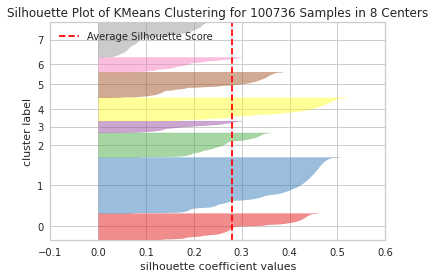

CPU times: user 17min 9s, sys: 17min 35s, total: 34min 44s
Wall time: 8min 41s


In [26]:
%%time
# Instantiate the clustering model and visualizer 
# model = 
visualizer = SilhouetteVisualizer(KMeans(8))

visualizer.fit(df_mmss)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

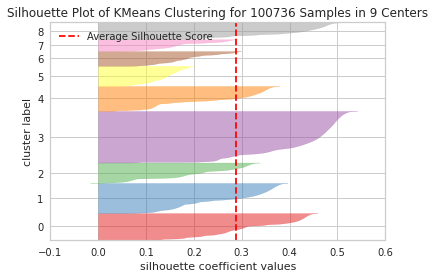

CPU times: user 17min 21s, sys: 17min 41s, total: 35min 2s
Wall time: 8min 43s


In [27]:
%%time
# Instantiate the clustering model and visualizer 
# model = 
visualizer = SilhouetteVisualizer(KMeans(9))

visualizer.fit(df_mmss)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

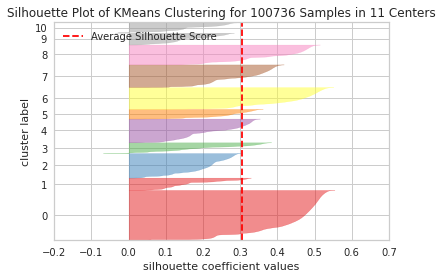

CPU times: user 16min 41s, sys: 17min 34s, total: 34min 15s
Wall time: 8min 26s


In [28]:
%%time
# Instantiate the clustering model and visualizer 
# model = 
visualizer = SilhouetteVisualizer(KMeans(11))

visualizer.fit(df_mmss)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

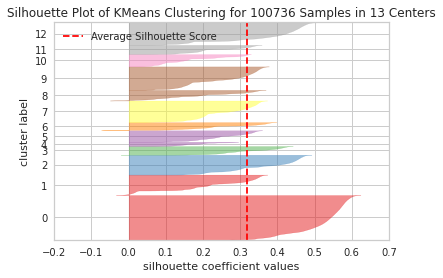

CPU times: user 16min 53s, sys: 17min 50s, total: 34min 43s
Wall time: 8min 34s


In [29]:
%%time
# Instantiate the clustering model and visualizer 
# model = 
visualizer = SilhouetteVisualizer(KMeans(13))

visualizer.fit(df_mmss)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

### DBSCAN

#### Cherche la Valeur EPS

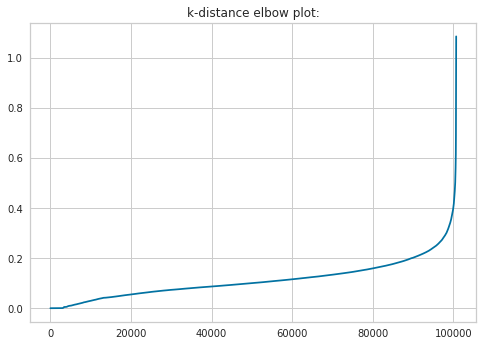

CPU times: user 3min 17s, sys: 1min 19s, total: 4min 37s
Wall time: 3min 3s


In [10]:
%%time
# find the eps using NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=29)
neighbors.fit(df_mmss)
distances, indices = neighbors.kneighbors(df_mmss)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.title('k-distance elbow plot:')
plt.plot(distances)
plt.show()

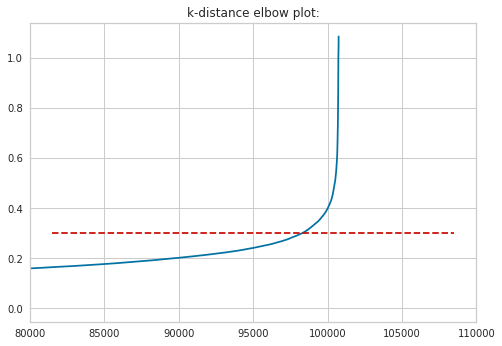

In [14]:
# zoom in plot
plt.title('k-distance elbow plot:')

plt.plot(distances)
plt.axhline(y=0.3, color='r', linestyle='--',xmin=0.05,xmax=0.95)
plt.xlim(80000, 110000)

plt.show()

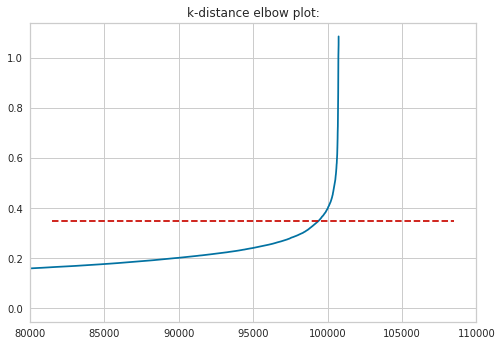

In [13]:
# zoom in plot
plt.title('k-distance elbow plot:')

plt.plot(distances)
plt.axhline(y=0.35, color='r', linestyle='--',xmin=0.05,xmax=0.95)
plt.xlim(80000, 110000)

plt.show()

#### DBSCAN

In [15]:
%%time
# instantiate and fit DBSCAN
db = DBSCAN(eps=0.35, min_samples=29)
db.fit(df_mmss)

# crate sample mask and get labels
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# calculate number of clusters
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

CPU times: user 1min 42s, sys: 1min 7s, total: 2min 49s
Wall time: 1min 16s


90

In [16]:
# calculate number of noise data points
n_noise_ = list(labels).count(-1)
n_noise_

6443

## Visualisation

### TSNE

#### iter = 2000

In [30]:
%%time
df_mmss_tsne = pd.DataFrame()
tsne = TSNE(n_components=2, perplexity=50, n_iter=2000, init="pca")
tsne = tsne.fit_transform(df_mmss)
df_mmss_tsne['dim_x'] = tsne[:,0]
df_mmss_tsne['dim_y'] = tsne[:,1]

CPU times: user 4h 46min 47s, sys: 10min 18s, total: 4h 57min 5s
Wall time: 41min 46s


In [31]:
def plot_tsne(x, y, data, hue, title=None):
    sns.lmplot(
        x=x,
        y=y,
        data=data,
        legend=True,
        height=9,
        hue=hue,
        scatter_kws={"s": 10, "alpha": 0.3},
        fit_reg=False,
    )

    if title is not None:
        plt.title(title, fontdict={'fontsize': 15})
    plt.show()

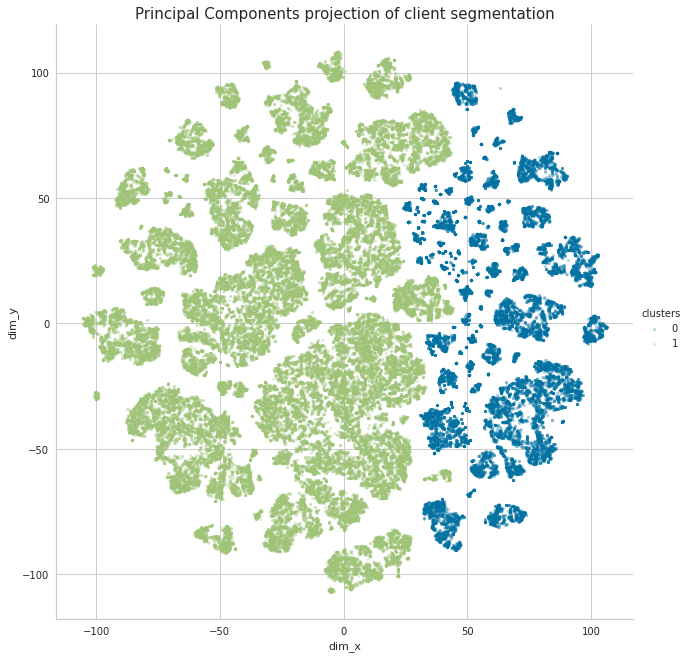

CPU times: user 19.7 s, sys: 4.09 s, total: 23.8 s
Wall time: 4.09 s


In [32]:
%%time
# k = 2
test = KMeans(n_clusters=2)
test = test.fit(df_mmss)
df_mmss_tsne['clusters'] = test.labels_
plot_tsne(
    x='dim_x',
    y='dim_y',
    data=df_mmss_tsne,
    hue='clusters',
    title="Principal Components projection of client segmentation",
)

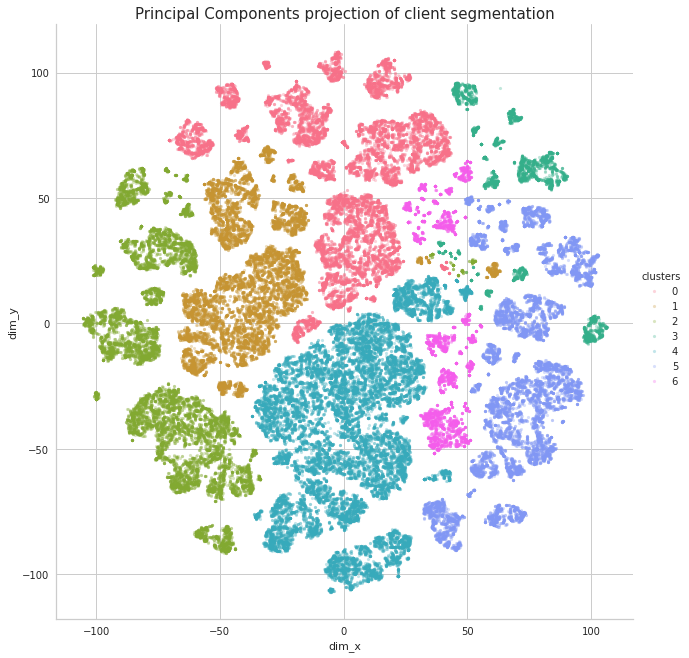

CPU times: user 28.3 s, sys: 8.36 s, total: 36.6 s
Wall time: 5.21 s


In [33]:
%%time
# k = 7
test = KMeans(n_clusters=7)
test = test.fit(df_mmss)
df_mmss_tsne['clusters'] = test.labels_
plot_tsne(
    x='dim_x',
    y='dim_y',
    data=df_mmss_tsne,
    hue='clusters',
    title="Principal Components projection of client segmentation",
)

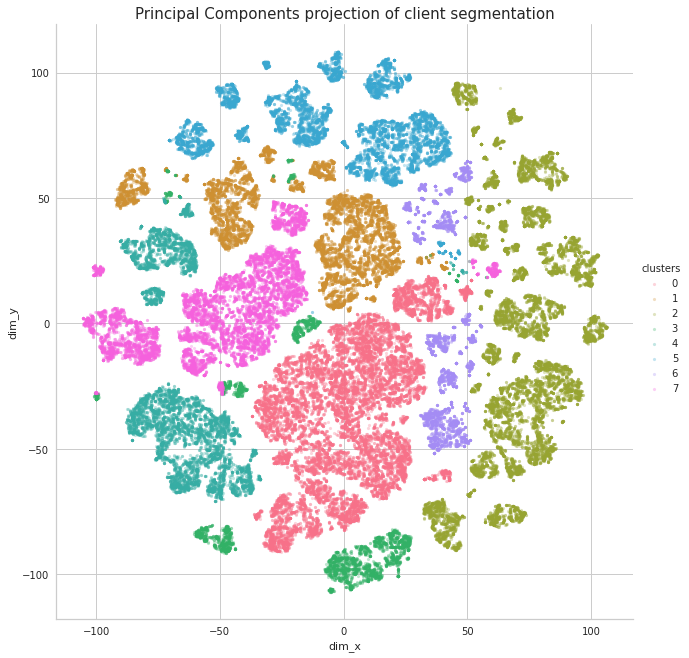

CPU times: user 29.4 s, sys: 7.77 s, total: 37.2 s
Wall time: 5.38 s


In [34]:
%%time
# k = 8
test = KMeans(n_clusters=8)
test = test.fit(df_mmss)
df_mmss_tsne['clusters'] = test.labels_
plot_tsne(
    x='dim_x',
    y='dim_y',
    data=df_mmss_tsne,
    hue='clusters',
    title="Principal Components projection of client segmentation",
)

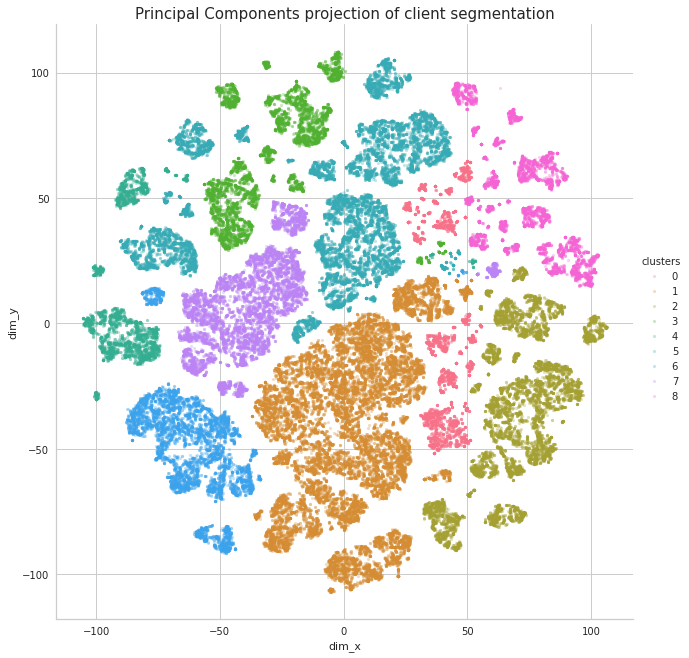

CPU times: user 32.7 s, sys: 10.2 s, total: 42.9 s
Wall time: 6.21 s


In [35]:
%%time
# k = 9
test = KMeans(n_clusters=9)
test = test.fit(df_mmss)
df_mmss_tsne['clusters'] = test.labels_
plot_tsne(
    x='dim_x',
    y='dim_y',
    data=df_mmss_tsne,
    hue='clusters',
    title="Principal Components projection of client segmentation",
)

#### iter = 3000

In [9]:
%%time
df_mmss_tsne_3k = pd.DataFrame()
tsne_3k = TSNE(n_components=2, perplexity=50, n_iter=1000, init="pca")
tsne_3k = tsne_3k.fit_transform(df_mmss)
df_mmss_tsne_3k['dim_x'] = tsne_3k[:,0]
df_mmss_tsne_3k['dim_y'] = tsne_3k[:,1]

CPU times: user 49.6 ms, sys: 875 µs, total: 50.5 ms
Wall time: 56.7 ms


In [10]:
def plot_tsne(x, y, data, hue, title=None):
    sns.lmplot(
        x=x,
        y=y,
        data=data,
        legend=True,
        height=9,
        hue=hue,
        scatter_kws={"s": 10, "alpha": 0.3},
        fit_reg=False,
    )

    if title is not None:
        plt.title(title, fontdict={'fontsize': 15})
    plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


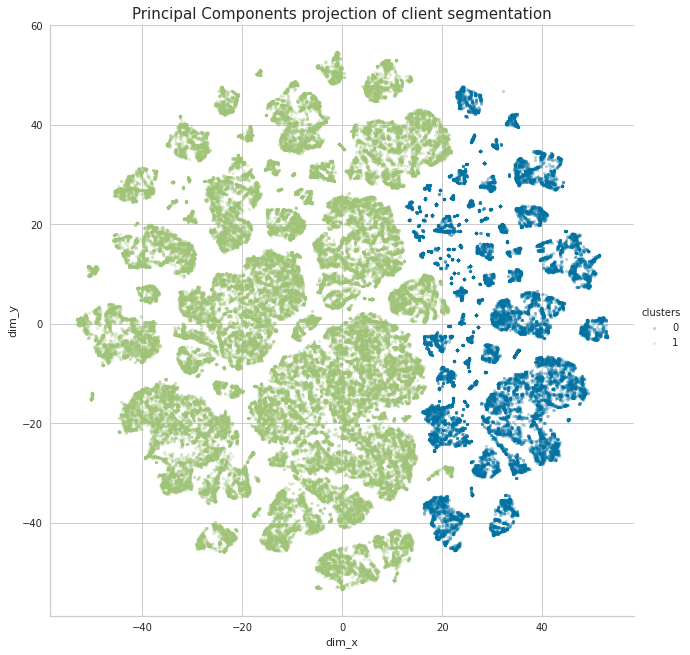

CPU times: user 16.3 s, sys: 4.19 s, total: 20.5 s
Wall time: 3.5 s


In [11]:
%%time
# k = 2
test = KMeans(n_clusters=2)
test = test.fit(df_mmss)
df_mmss_tsne_3k['clusters'] = test.labels_
plot_tsne(
    x='dim_x',
    y='dim_y',
    data=df_mmss_tsne_3k,
    hue='clusters',
    title="Principal Components projection of client segmentation",
)

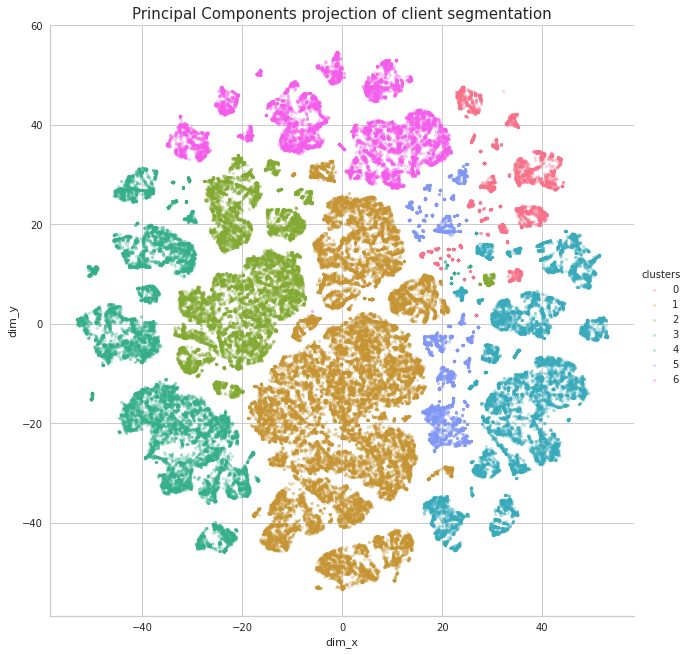

CPU times: user 22.3 s, sys: 6.95 s, total: 29.2 s
Wall time: 4.27 s


In [12]:
%%time
# k = 7
test = KMeans(n_clusters=7)
test = test.fit(df_mmss)
df_mmss_tsne_3k['clusters'] = test.labels_
plot_tsne(
    x='dim_x',
    y='dim_y',
    data=df_mmss_tsne_3k,
    hue='clusters',
    title="Principal Components projection of client segmentation",
)

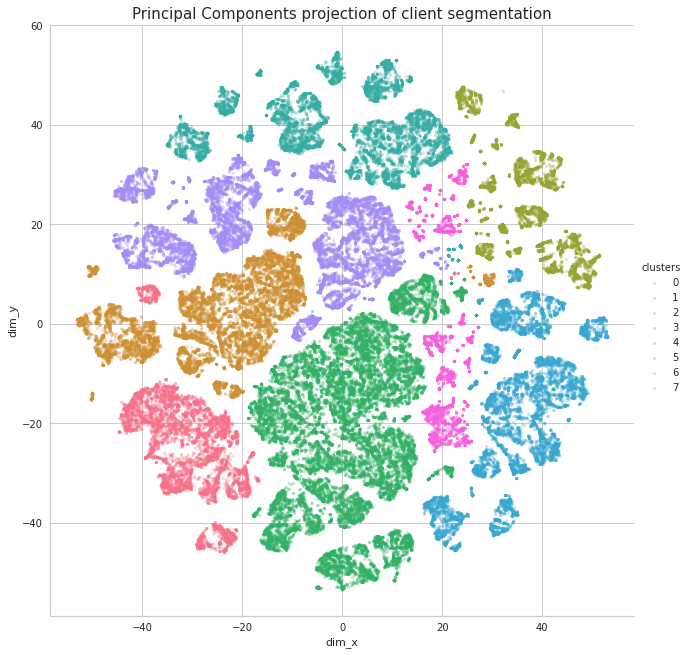

CPU times: user 24.1 s, sys: 8.15 s, total: 32.3 s
Wall time: 4.66 s


In [13]:
%%time
# k = 8
test = KMeans(n_clusters=8)
test = test.fit(df_mmss)
df_mmss_tsne_3k['clusters'] = test.labels_
plot_tsne(
    x='dim_x',
    y='dim_y',
    data=df_mmss_tsne_3k,
    hue='clusters',
    title="Principal Components projection of client segmentation",
)

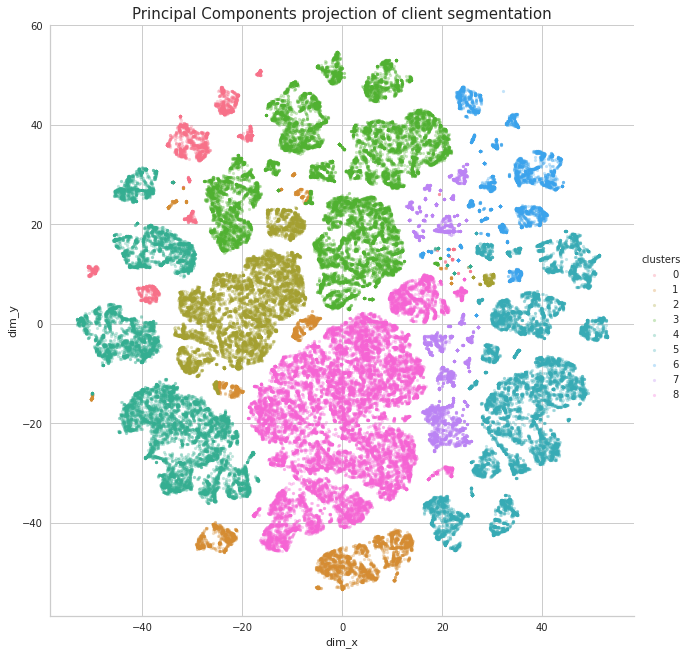

CPU times: user 26.8 s, sys: 9.61 s, total: 36.4 s
Wall time: 6.01 s


In [14]:
%%time
# k = 9
test = KMeans(n_clusters=9)
test = test.fit(df_mmss)
df_mmss_tsne_3k['clusters'] = test.labels_
plot_tsne(
    x='dim_x',
    y='dim_y',
    data=df_mmss_tsne_3k,
    hue='clusters',
    title="Principal Components projection of client segmentation",
)

### UMAP

In [34]:
%%time
clusterable_embedding = umap.UMAP(
    n_neighbors=29,
    min_dist=0.0,
    n_components=2,
    random_state=42,
)
clusterable_embedding = clusterable_embedding.fit_transform(df_mmss)
df_mmss_umap = pd.DataFrame()
df_mmss_umap['dim_x'] = clusterable_embedding[:, 0]
df_mmss_umap['dim_y'] = clusterable_embedding[:, 1]

CPU times: user 12min 24s, sys: 8min 42s, total: 21min 6s
Wall time: 4min 45s


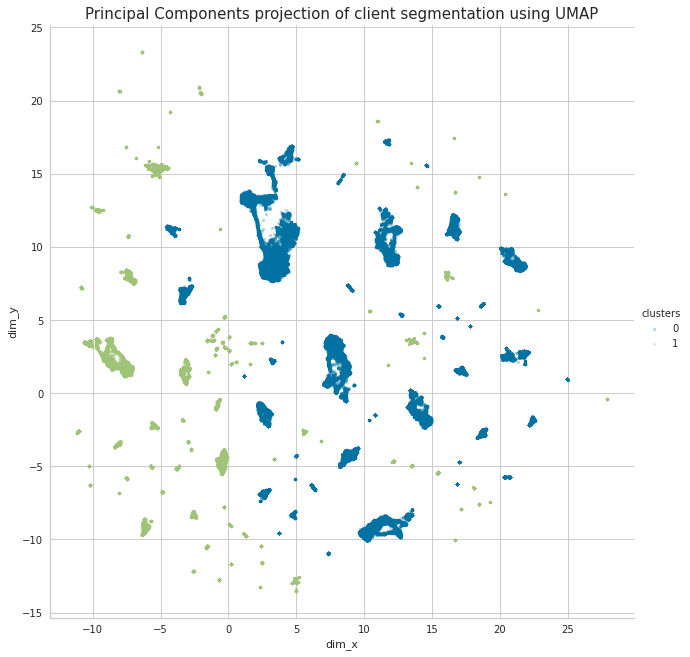

CPU times: user 16.4 s, sys: 3.28 s, total: 19.7 s
Wall time: 2.6 s


In [35]:
%%time
# k = 2
test = KMeans(n_clusters=2)
test = test.fit(df_mmss)
df_mmss_umap['clusters'] = test.labels_
plot_clusters(
    x='dim_x',
    y='dim_y',
    data=df_mmss_umap,
    hue='clusters',
    title="Principal Components projection of client segmentation using UMAP",
)

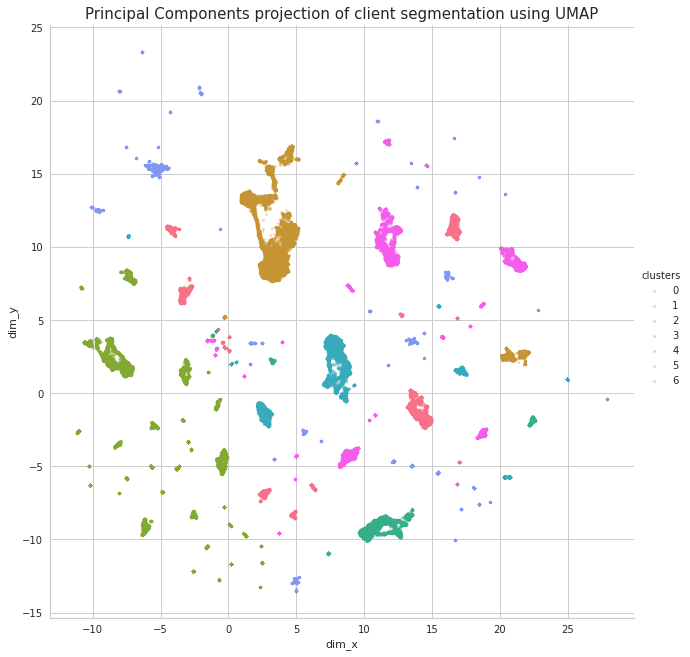

CPU times: user 26.3 s, sys: 5.94 s, total: 32.3 s
Wall time: 4.34 s


In [36]:
%%time
# k = 7
test = KMeans(n_clusters=7)
test = test.fit(df_mmss)
df_mmss_umap['clusters'] = test.labels_
plot_clusters(
    x='dim_x',
    y='dim_y',
    data=df_mmss_umap,
    hue='clusters',
    title="Principal Components projection of client segmentation using UMAP",
)

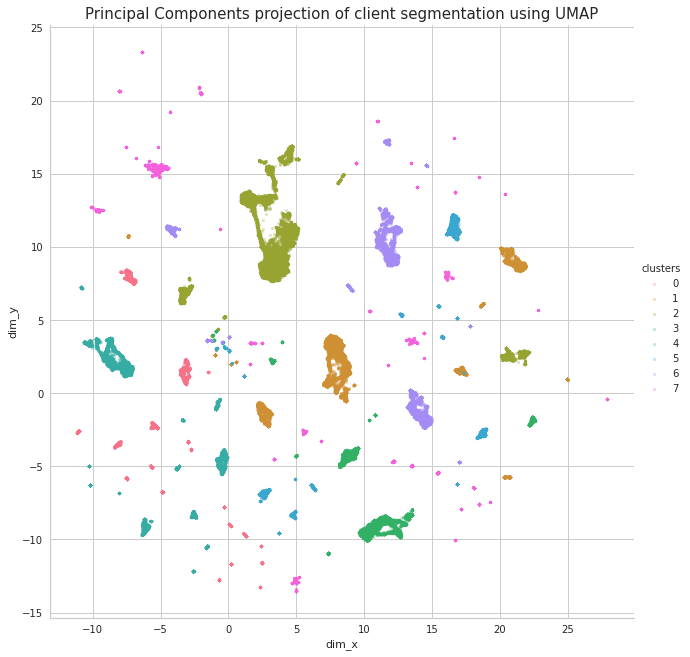

CPU times: user 26.8 s, sys: 6.68 s, total: 33.5 s
Wall time: 4.53 s


In [37]:
%%time
# k = 8
test = KMeans(n_clusters=8)
test = test.fit(df_mmss)
df_mmss_umap['clusters'] = test.labels_
plot_clusters(
    x='dim_x',
    y='dim_y',
    data=df_mmss_umap,
    hue='clusters',
    title="Principal Components projection of client segmentation using UMAP",
)

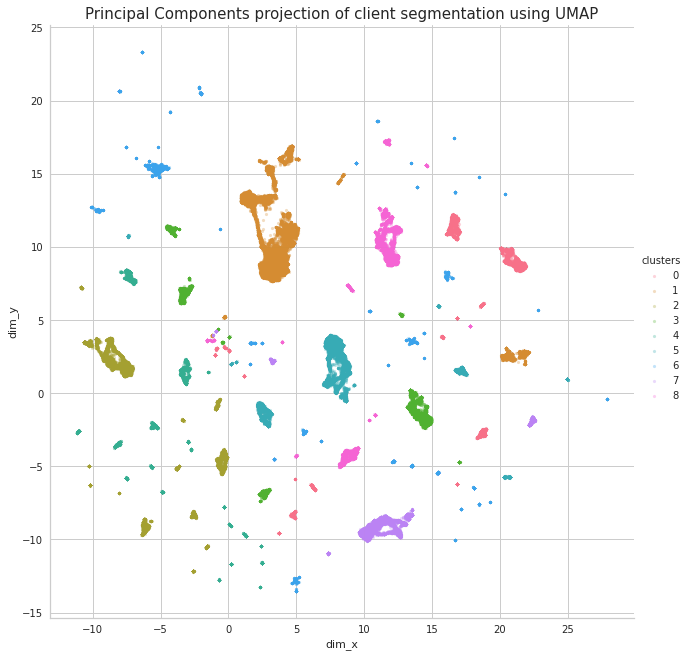

CPU times: user 27.9 s, sys: 6.87 s, total: 34.7 s
Wall time: 4.65 s


In [38]:
%%time
# k = 9
test = KMeans(n_clusters=9)
test = test.fit(df_mmss)
df_mmss_umap['clusters'] = test.labels_
plot_clusters(
    x='dim_x',
    y='dim_y',
    data=df_mmss_umap,
    hue='clusters',
    title="Principal Components projection of client segmentation using UMAP",
)

## Anaylse des Clusters

### 7 Clusters

In [40]:
%%time
# k = 7
km7 = KMeans(n_clusters=7)
km7 = km7.fit(df_mmss)
df_mmss_umap['clusters'] = km7.labels_

CPU times: user 18.6 s, sys: 6 s, total: 24.6 s
Wall time: 3.27 s


In [46]:
df_analyse = df_mmss.copy()
df_analyse['clusters'] = km7.labels_

In [157]:
clusters = {}
for cluster in range(7):
    clusters[cluster] = list(
        df_analyse[df_analyse.clusters == cluster].iloc[:, :-1].mean().values
    )
    clusters[cluster] = [*clusters[cluster], clusters[cluster][0]]

In [185]:
%%time
plot_radar(clusters[0], title='Client Segmentation - cluster 0')

CPU times: user 9.94 ms, sys: 0 ns, total: 9.94 ms
Wall time: 9.61 ms


**Cluster 0**
1. price = 0.5
2. long product name = 1
3. review score a bit higher than 0.8
4. 

In [186]:
%%time
plot_radar(clusters[1], title='Client Segmentation - cluster 1')

CPU times: user 9.26 ms, sys: 1.85 ms, total: 11.1 ms
Wall time: 10.4 ms


**Cluster 1**<br>
Weekend and holiday buyers and credit card users

1. price = 0.5
2. product name = 0.65
3. review score = 0.8
4. 

In [187]:
%%time
plot_radar(clusters[2], title='Client Segmentation - cluster 2')

CPU times: user 7.65 ms, sys: 1.64 ms, total: 9.29 ms
Wall time: 8.54 ms


**Cluster 2**<br>
Holiday buyers and credit card users

1. price = 0.5
2. product name = 0.65
3. review score = 0.8
4. 

In [188]:
%%time
plot_radar(clusters[3], title='Client Segmentation - cluster 3')

CPU times: user 8.85 ms, sys: 1.05 ms, total: 9.9 ms
Wall time: 9.4 ms


**Cluster 3**<br>
Holiday buyers and credit card users, neighbour shoppers

1. price = 0.5
2. product name = 0.65
3. review score = 0.8
4. 

In [189]:
%%time
plot_radar(clusters[4], title='Client Segmentation - cluster 4')

CPU times: user 6.87 ms, sys: 2.3 ms, total: 9.17 ms
Wall time: 8.6 ms


**Cluster 4**<br>
Semi Holiday buyers, boleto users, semi neighbour shoppers

1. price = 0.5
2. product name = 0.65
3. review score a bit higher than 0.8
4. 

In [190]:
%%time
plot_radar(clusters[5], title='Client Segmentation - cluster 5')

CPU times: user 8.47 ms, sys: 265 µs, total: 8.74 ms
Wall time: 8.41 ms


**Cluster 5**<br>
Happy buyers, credit card users, neighbour shoppers

1. price = 0.5
2. product name = 0.65
3. high review score close to 0.9
4. 

In [191]:
%%time
plot_radar(clusters[6], title='Client Segmentation - cluster 6')

CPU times: user 8.12 ms, sys: 722 µs, total: 8.84 ms
Wall time: 8.07 ms


**Cluster 6**<br>
??

1. price = 0.5
2. product name = 0.65
3. high review score close to 0.9
4. 